<a href="https://colab.research.google.com/github/ntjz-kakarot/llms-for-mitre-flows/blob/main/CTI_to_Graph_Mistral_7B_Instruct_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup the environment

In [1]:
!pip install -qU \
  pdfplumber \
  python-docx \
  bitsandbytes \
  accelerate \
  mitreattack-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 780.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.1/546.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [34]:
# Standard library imports
import io
import json
import logging
import re
import time
from datetime import datetime
import uuid
import locale
from dataclasses import dataclass
from io import BytesIO
import requests

# Third-party library imports for data manipulation and analysis
import numpy as np
import pandas as pd

# Text and file processing libraries
import pdfplumber
import html
from bs4 import BeautifulSoup
from PIL import Image
import textwrap
import docx

# Machine Learning, NLP, and PyTorch libraries
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig

# Visualization and display libraries
from IPython.display import HTML, display
from IPython.display import Image as IPythonImage
import graphviz
from tabulate import tabulate

# Google Colab specific utilities
from google.colab import userdata
from ipywidgets import FileUpload, widgets

# Load MITRE ATT&CK data
from mitreattack.stix20 import MitreAttackData
!wget -q https://raw.githubusercontent.com/mitre-attack/attack-stix-data/master/enterprise-attack/enterprise-attack.json
mitre_attack_data = MitreAttackData("enterprise-attack.json")

In [3]:
# Override the system's preferred encoding to "UTF-8"
locale.getpreferredencoding = lambda do_setlocale=True: "UTF-8"

# Set 'HUGGINGFACE_AUTH_TOKEN' in the Google Colab Secrets
HF_TOKEN = userdata.get('HUGGINGFACE_AUTH_TOKEN')
if HF_TOKEN is None:
    raise ValueError("Hugging Face authentication token not found. Set the HUGGINGFACE_AUTH_TOKEN environment variable.")

## Class Definitions

### Document Processor Class

In [8]:
class DocumentProcessor:
    def __init__(self):
        self.pages_to_exclude = set()
        self.files_content = {}
        self.upload_widget = FileUpload(multiple=True)
        self.setup_widgets()

    def setup_widgets(self):
        start_page_input = widgets.IntText(description="Start Page:")
        end_page_input = widgets.IntText(description="End Page:")
        exclude_pages_button = widgets.Button(description="Exclude Pages")
        exclude_pages_button.on_click(lambda b: self.on_exclude_pages_click(start_page_input, end_page_input))

        process_files_button = widgets.Button(description="Process Files")
        process_files_button.on_click(lambda b: self.on_process_files_click())

        display(self.upload_widget, start_page_input, end_page_input, exclude_pages_button, process_files_button)

    def on_exclude_pages_click(self, start_page_input, end_page_input):
        start_page = start_page_input.value
        end_page = end_page_input.value
        self.pages_to_exclude.update(range(start_page, end_page + 1))
        print(f"Pages {start_page} to {end_page} will be excluded.")

    def on_process_files_click(self):
        self.process_files()
        print("Files processed and stored.")

    def parse_text(self, file_name: str, content: io.BytesIO) -> str:
        if file_name.endswith('.pdf'):
            with pdfplumber.open(content) as pdf:
                text = " ".join(
                    page.extract_text() for i, page in enumerate(pdf.pages, start=1) if i not in self.pages_to_exclude
                )
        elif file_name.endswith('.html'):
            text = BeautifulSoup(content.read().decode('utf-8'), features="html.parser").get_text()
        elif file_name.endswith('.txt'):
            text = content.read().decode('utf-8')
        elif file_name.endswith('.docx'):
            doc = docx.Document(content)
            text = " ".join(
                paragraph.text for i, paragraph in enumerate(doc.paragraphs, start=1) if i not in self.pages_to_exclude
            )
        else:
            raise ValueError(f"Unsupported file type: {file_name}")

        cleaned_text = re.sub(r'\s+', ' ', text).strip()
        return cleaned_text

    def process_files(self):
        for name, content in self.upload_widget.value.items():
            text = self.parse_text(name, io.BytesIO(content['content']))
            self.files_content[name] = text

    def get_processed_texts(self):
        return self.files_content

    def display_processed_texts(self):
        for doc_name, doc_content in self.files_content.items():
            word_count = len(doc_content.split())
            print(f"Document: {doc_name}")
            print(f"Word Count: {word_count}")
            print(f"Content: {doc_content[:100]}...")
            print("-" * 100)

### Model Loader Class

In [9]:
class ModelLoader:
    def __init__(self, model_id: str, hf_token: str):
        self.model_id = model_id
        self.hf_token = hf_token
        self.device = torch.device(f'cuda:{torch.cuda.current_device()}') if torch.cuda.is_available() else torch.device('cpu')
        self.bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type='nf4', bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype='bfloat16')
        self.model, self.tokenizer = self.load_model_and_tokenizer()

    def load_model_and_tokenizer(self):
        try:
            model_config = transformers.AutoConfig.from_pretrained(
                self.model_id,
                token=self.hf_token,
            )
            model = transformers.AutoModelForCausalLM.from_pretrained(
                self.model_id,
                trust_remote_code=True,
                config=model_config,
                quantization_config=self.bnb_config,
                device_map='auto',
                token=self.hf_token
            ).eval()

            tokenizer = transformers.AutoTokenizer.from_pretrained(
                self.model_id,
                token=self.hf_token
            )

            print(f"Model loaded on {'GPU: ' + torch.cuda.get_device_name(self.device) if torch.cuda.is_available() else 'CPU'} - {self.device}")
            return model, tokenizer
        except Exception as e:
            print(f"Failed to load model or tokenizer: {e}")
            return None, None

### Answer and Prompt Processor Class

In [57]:
@dataclass
class Answer:
    answer: str
    elapse: int

class PromptProcessor:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def generate(self, prompt: str) -> str:
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        outputs = self.model.generate(
            **inputs,
            max_new_tokens=4096,
            do_sample=False,
            num_return_sequences=1,
            repetition_penalty=1.0,
            length_penalty=1.0
        )
        prompt_length = inputs['input_ids'].shape[1]
        return self.tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)

    def run_prompt(self, prompt: str) -> Answer:
        start_time = time.time()
        answer_text = self.generate(prompt)
        elapse_time = round(time.time() - start_time)
        return Answer(answer_text, elapse_time)

    # def process_answer(self, answer: Answer) -> dict:
    #     print(f"Time to Generate: {answer.elapse} seconds")

    #     print("Raw answer:")
    #     print(answer.answer)
    #     print()

    def process_answer(self, answer: Answer) -> dict:
        print(f"Time to Generate: {answer.elapse} seconds")

        try:
            # Remove problematic escape sequences from the answer
            cleaned_answer = re.sub(r'\\\*|\\\\|\\"|\\', '', answer.answer)

            parsed_json = json.loads(cleaned_answer)
            print(json.dumps(parsed_json, indent=4))
            return parsed_json
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON from the answer: {e}")
            return {}

### Graph Generator Class

In [81]:
class GraphGenerator:
    VIZ_IGNORE_COMMON_PROPERTIES = (
        "created",
        "external_references",
        "id",
        "modified",
        "revoked",
        "spec_version",
        "type",
    )

    VIZ_IGNORE_SDOS = ("attack-flow", "extension-definition")

    def convert_json_to_stix(self, json_data):
        created_date = "2023-04-08T00:00:00.000Z"
        modified_date = datetime.now().strftime('%Y-%m-%dT%H:%M:%S.%fZ')
        # Create a dictionary to store the STIX bundle
        stix_bundle = {
            "type": "bundle",
            "id": "bundle--" + str(uuid.uuid4()),
            "objects": []
        }

        # Create a dictionary to store the mapping of action names to their corresponding STIX IDs
        action_id_mapping = {}

        # Iterate over each action in the JSON data
        for action in json_data:
            # Get the technique and technique_ref using mitre_attack_data
            if action.get('sub_technique_id'):
                technique_id = action['sub_technique_id']
            else:
                technique_id = action['technique_id']

            technique_obj = mitre_attack_data.get_object_by_attack_id(technique_id, 'attack-pattern')

            if technique_obj is None:
                continue

            technique = technique_obj['name']
            technique_ref = technique_obj['id']

            # Create an Attack Action object for each action
            attack_action = {
                "type": "attack-action",
                "id": "attack-action--" + str(uuid.uuid4()),
                "spec_version": "2.1",
                "created": created_date,
                "modified": modified_date,
                "extensions": {
                    "extension-definition--fb9c968a-745b-4ade-9b25-c324172197f4": {
                        "extension_type": "new-sdo"
                    }
                },
                "name": action["action_name"],
                "technique": technique,
                "technique_ref": technique_ref,
                "description": action["evidence"]
            }
            stix_bundle["objects"].append(attack_action)

            # Store the mapping of action name to its STIX ID
            action_id_mapping[action["action_name"]] = attack_action["id"]

            # Create an Asset object for each affected asset
            for asset in action["affected_assets"]:
                asset = {
                    "type": "asset",
                    "id": "asset--" + str(uuid.uuid4()),
                    "spec_version": "2.1",
                    "created": created_date,
                    "modified": modified_date,
                    "name": asset
                }
                stix_bundle["objects"].append(asset)

                # Create a Relationship object between the Attack Action and Asset
                relationship = {
                    "type": "relationship",
                    "id": "relationship--" + str(uuid.uuid4()),
                    "spec_version": "2.1",
                    "created": created_date,
                    "modified": modified_date,
                    "relationship_type": "affects",
                    "source_ref": attack_action["id"],
                    "target_ref": asset["id"]
                }
                stix_bundle["objects"].append(relationship)

            # Create Vulnerability objects for the exploited vulnerabilities (if provided)
            if action.get("exploited_vulnerability"):
                vulnerability = {
                    "type": "vulnerability",
                    "id": "vulnerability--" + str(uuid.uuid4()),
                    "spec_version": "2.1",
                    "created": created_date,
                    "modified": modified_date,
                    "name": action["exploited_vulnerability"],
                    "external_references": [
                        {
                            "source_name": "cve",
                            "external_id": action["exploited_vulnerability"]
                        }
                    ]
                }
                stix_bundle["objects"].append(vulnerability)

                # Create a Relationship object between the Attack Action and Vulnerability
                relationship = {
                    "type": "relationship",
                    "id": "relationship--" + str(uuid.uuid4()),
                    "spec_version": "2.1",
                    "created": created_date,
                    "modified": modified_date,
                    "relationship_type": "exploits",
                    "source_ref": attack_action["id"],
                    "target_ref": vulnerability["id"]
                }
                stix_bundle["objects"].append(relationship)

        # Create Relationship objects for the proceeding actions
        for action in json_data:
            if action["action_name"] not in action_id_mapping:
                continue

            source_action_id = action_id_mapping[action["action_name"]]
            for proceeding_action in action["proceeding_actions"]:
                if proceeding_action in action_id_mapping:
                    target_action_id = action_id_mapping[proceeding_action]
                    relationship = {
                        "type": "relationship",
                        "id": "relationship--" + str(uuid.uuid4()),
                        "spec_version": "2.1",
                        "created": created_date,
                        "modified": modified_date,
                        "relationship_type": "proceeds-to",
                        "source_ref": source_action_id,
                        "target_ref": target_action_id
                    }
                    stix_bundle["objects"].append(relationship)

        # Add the extension definition and identity objects
        extension_definition = {
            "type": "extension-definition",
            "id": "extension-definition--fb9c968a-745b-4ade-9b25-c324172197f4",
            "spec_version": "2.1",
            "name": "Attack Flow",
            "description": "Extends STIX 2.1 with features to create Attack Flows.",
            "created": "2022-08-02T19:34:35.143Z",
            "modified": "2022-08-02T19:34:35.143Z",
            "created_by_ref": "identity--d673f8cb-c168-42da-8ed4-0cb26725f86c",
            "schema": "https://center-for-threat-informed-defense.github.io/attack-flow/stix/attack-flow-schema-2.0.0.json",
            "version": "2.0.0",
            "extension_types": [
                "new-sdo"
            ],
            "external_references": [
                {
                    "source_name": "Documentation",
                    "description": "Documentation for Attack Flow",
                    "url": "https://center-for-threat-informed-defense.github.io/attack-flow"
                },
                {
                    "source_name": "GitHub",
                    "description": "Source code repository for Attack Flow",
                    "url": "https://github.com/center-for-threat-informed-defense/attack-flow"
                }
            ]
        }
        stix_bundle["objects"].append(extension_definition)

        identity = {
            "type": "identity",
            "spec_version": "2.1",
            "id": "identity--d673f8cb-c168-42da-8ed4-0cb26725f86c",
            "created": "2022-08-02T19:34:35.143Z",
            "modified": "2022-08-02T19:34:35.143Z",
            "name": "MITRE Engenuity Center for Threat-Informed Defense",
            "identity_class": "organization"
        }
        stix_bundle["objects"].append(identity)

        # identity of the attackflow's author
        my_id = "identity--2294b27e-f6ef-11ee-8bc4-0242ac1c0002"
        id_me = {
            "type": "identity",
            "id": my_id,
            "spec_version": "2.1",
            "created": created_date,
            "modified": modified_date,
            "name": "Nipuna Jayasekara"
        }
        stix_bundle["objects"].append(id_me)

        # Attack Flow Element
        attack_flow_id = "attack-flow--" + str(uuid.uuid1())
        attack_flow_name = f"{attack_name} Attack Flow"
        attack_flow = {
            "type": "attack-flow",
            "id": attack_flow_id,
            "spec_version": "2.1",
            "created": created_date,
            "modified": modified_date,
            "extensions": extension_definition,
            "created_by_ref": my_id,
            "name": attack_flow_name,
            "scope": "incident"
        }
        stix_bundle["objects"].append(attack_flow)

        return stix_bundle

    def label_escape(self, text):
        if text is None:
            return ""
        return graphviz.escape(html.escape(text))

    def convert2dot(self, StixBundle):
        dotObj = graphviz.Digraph()
        dotObj.body = self._get_body_label(StixBundle)
        ignored_ids = self.get_ignored_ids(StixBundle)

        for o in StixBundle['objects']:
            if o['type'] == "attack-action":
                dotObj.node(o['id'], self._get_action_label(o), shape="plaintext")
                for ref in o.get("asset_refs", []):
                    dotObj.edge(o['id'], ref, "asset")
                for ref in o.get("effect_refs", []):
                    dotObj.edge(o['id'], ref, "effect")

            elif o['type'] == "attack-asset":
                dotObj.node(o['id'], self._get_asset_label(o), shape="plaintext")
                if object_ref := o.get("object_ref"):
                    dotObj.edge(o['id'], object_ref, "object")

            elif o['type'] == "attack-condition":
                dotObj.node(o['id'], self._get_condition_label(o), shape="plaintext")
                for ref in o.get("on_true_refs", []):
                    dotObj.edge(o['id'], ref, "on_true")
                for ref in o.get("on_false_refs", []):
                    dotObj.edge(o['id'], ref, "on_false")

            elif o['type'] == "attack-operator":
                dotObj.node(o['id'], o['operator'], shape="circle", style="filled", fillcolor="#ff9900")
                for ref in o.get("effect_refs", []):
                    dotObj.edge(o['id'], ref, "effect")

            elif o['type'] == "relationship":
                dotObj.edge(o['source_ref'], o['target_ref'], o['relationship_type'])

            elif o['id'] not in ignored_ids:
                dotObj.node(o['id'], self._get_builtin_label(o), shape="plaintext")

        return dotObj

    def _get_body_label(self, StixBundle):
        flow = self.get_flow_object(StixBundle)

        if flow is None:
            return []

        author = self.get_obj(StixBundle, flow['created_by_ref'])

        description = "<br/>".join(
            textwrap.wrap(
                self.label_escape(flow.get("description", f"This is an Attack Flow Graph generated from {doc_name}")), width=100
            )
        )
        lines = [
            f'<font point-size="24">{self.label_escape(flow["name"])}</font>',
            f"<i>{description}</i>",
            f'<font point-size="10">Author: {self.label_escape(author.get("name", "(missing)"))} &lt;{self.label_escape(author.get("contact_information", "n/a"))}&gt;</font>',
            f'<font point-size="10">Created: {flow.get("created", "(missing)")}</font>',
            f'<font point-size="10">Modified: {flow.get("modified", "(missing)")}</font>',
        ]
        label = "<br/>".join(lines)

        return [f"\tlabel=<{label}>;\n", '\tlabelloc="t";\n']

    def _get_action_label(self, StixBundle):
        if tid := StixBundle.get("technique_id", None):
            heading = f"Action: {tid}"
        else:
            heading = "Action"
        description = "<br/>".join(
            textwrap.wrap(self.label_escape(StixBundle.get("description", "")), width=40)
        )

        name = self.label_escape(StixBundle['name'])

        return "".join(
            [
                '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5">',
                f'<TR><TD BGCOLOR="#99ccff" COLSPAN="2"><B>{heading}</B></TD></TR>',
                f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Name</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{name}</TD></TR>',
                f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Description</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{description}</TD></TR>'
                "</TABLE>>",
            ]
        )

    def _get_asset_label(self, StixBundle):
        name = self.label_escape(StixBundle['name'])
        description = "<br/>".join(
            textwrap.wrap(self.label_escape(StixBundle.get("description", "")), width=40)
        )
        return "".join(
            [
                '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5">',
                f'<TR><TD BGCOLOR="#ee00ff" COLSPAN="2"><B>Asset: {name}</B></TD></TR>',
                f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Description</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{description}</TD></TR>',
                "</TABLE>>",
            ]
        )

    def _get_condition_label(self, StixBundle):
        description = "<br/>".join(
            textwrap.wrap(self.label_escape(StixBundle.description), width=40)
        )
        return "".join(
            [
                '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5">',
                '<TR><TD BGCOLOR="#99ff99" COLSPAN="2"><B>Condition</B></TD></TR>',
                f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>Description</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{description}</TD></TR>'
                "</TABLE>>",
            ]
        )

    def _get_builtin_label(self, StixBundle):
        title = StixBundle['type'].replace("-", " ").title()
        lines = [
            '<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="5">',
            f'<TR><TD BGCOLOR="#cccccc" COLSPAN="2"><B>{title}</B></TD></TR>',
        ]
        for key, value in StixBundle.items():
            if key in self.VIZ_IGNORE_COMMON_PROPERTIES:
                continue
            pretty_key = key.replace("_", " ").title()
            if isinstance(value, list):
                value = ", ".join(str(v) for v in value)
            pretty_value = self.label_escape(str(value))
            lines.append(
                f'<TR><TD ALIGN="LEFT" BALIGN="LEFT"><B>{pretty_key}</B></TD><TD ALIGN="LEFT" BALIGN="LEFT">{pretty_value}</TD></TR>'
            )
        lines.append("</TABLE>>")
        return "".join(lines)

    def get_flow_object(self, StixBundle):
        for obj in StixBundle['objects']:
            if obj['type'] == "attack-flow":
                return obj
        return None

    def get_obj(self, StixBundle, id):
        for obj in StixBundle['objects']:
            if obj['id'] == id:
                return obj
        return None

    def get_ignored_ids(self, StixBundle):
        ignored = set()

        # Ignore flow creator identity:
        flow = self.get_flow_object(StixBundle)
        if flow and (flow_creator := flow.get("created_by_ref", None)):
            ignored.add(flow_creator)

        # Ignore by SDO type:
        for obj in StixBundle['objects']:
            if obj['type'] in self.VIZ_IGNORE_SDOS:
                ignored.add(obj['id'])

            # Ignore extension creator identity:
            if obj['type'] == "extension-definition" and (ext_creator := obj.get("created_by_ref", None)):
                ignored.add(ext_creator)

        return ignored

### Results Evaluation Class

In [36]:
results_dict = {}

class ResultsEvaluation:
    def __init__(self, stix_bundle, attack_name):
        self.stix_bundle = stix_bundle
        self.attack_name = attack_name
        self.mitre_url = input("Enter the MITRE ATTACK STIX URL: ")

    def evaluate(self):
        # Save stix_bundle to a new variable with a unique name
        unique_bundle_name = f"{self.attack_name}_stix_bundle"
        globals()[unique_bundle_name] = self.stix_bundle

        # Extract name, technique, and technique_ref from attack-action objects
        attack_action_data = []
        for obj in self.stix_bundle['objects']:
            if obj['type'] == 'attack-action' and 'technique_ref' in obj:
                attack_action_data.append({
                    'name': obj['name'],
                    'technique': obj['technique'],
                    'technique_ref': obj['technique_ref']
                })

        # Create a DataFrame from the extracted data
        df_attack_action = pd.DataFrame(attack_action_data)

        # Download and load the MITRE ATTACK STIX JSON
        response = requests.get(self.mitre_url)
        mitre_stix_bundle = response.json()

        # Extract name, technique_id, and technique_ref from MITRE ATTACK STIX
        mitre_attack_action_data = []
        for obj in mitre_stix_bundle['objects']:
            if obj['type'] == 'attack-action' and 'technique_ref' in obj:
                mitre_attack_action_data.append({
                    'name': obj['name'],
                    'technique_id': obj['technique_id'],
                    'technique_ref': obj['technique_ref']
                })

        # Create a DataFrame from the MITRE ATTACK data
        df_mitre_attack_action = pd.DataFrame(mitre_attack_action_data)

        # Calculate the accuracy based on technique_ref
        mitre_technique_refs = set(df_mitre_attack_action['technique_ref'])
        attack_action_technique_refs = set(df_attack_action['technique_ref'])
        common_technique_refs = mitre_technique_refs.intersection(attack_action_technique_refs)
        accuracy = len(common_technique_refs) / len(mitre_technique_refs) * 100

        # Store the evaluation result in the results_dict
        results_dict[self.attack_name] = accuracy

        print(f"Accuracy: {accuracy:.2f}%")

## Prompt Engineering

In [13]:
prompt = """<s>[INST] <<SYS>>
You are a cybersecurity analyst with expertise in the MITRE ATT&CK framework. Your task is to process the given section of a Cyber Threat Intelligence (CTI) report, which has been parsed and includes only the relevant parts pertaining to an attack's timeline. You will analyze the text sentence-by-sentence, and when necessary, consider additional sentences for context, to identify specific actions taken by attackers.
For each action identified, you will output information in JSON format with the following structure:

1. Action Name: The specific action taken by the attacker, as described in the text, like 'Vulnerability Scanning', 'Exploit Public-Facing Application', etc.
2. Tactic ID: The Tactic ID from the MITRE ATT&CK framework that categorizes the overarching goal of the action (e.g., TA0001 for Initial Access).
3. Technique ID/Sub-technique ID: The specific Technique or Sub-technique ID from the MITRE ATT&CK framework that the action corresponds to.
4. Evidence: A direct quote from the CTI report that supports the identification of the action.
5. Affected Asset(s): The asset(s) targeted or compromised by the action, based on the report's context.
6. Exploited Vulnerability: Name the specific vulnerability exploited by the action, if applicable.
7. Proceeding Actions: List the actions that directly follow the identified one, in chronological order, to help construct an attack flow graph.

Your response should be structured as follows (sample JSON for guidance):

{{
  "action_name": "Example Action",
  "tactic_id": "TA000X",
  "technique_id": "TXXXX",
  "sub_technique_id": "TXXXX.YYY",
  "evidence": "Exact text from the CTI report evidencing the action.",
  "affected_assets": ["Example Affected Asset"],
  "exploited_vulnerability": "CVE-XXXX-XXXX",
  "proceeding_actions": ["Next Action in the flow"]
}}

Ensure each identified action from the CTI report is processed into a separate JSON object.
<</SYS>>

What are the specific attacker actions described in the report, and how do they map to the MITRE ATT&CK framework? For each identified action, provide the action name, tactic ID, technique ID (and sub-technique ID if applicable), supporting evidence from the report, affected asset(s), exploited vulnerability (if any), and proceeding actions in the attack flow. [/INST]
[
{{
"action_name": "Vulnerability Scanning",
"tactic_id": "TA0001",
"technique_id": "T1595",
"sub_technique_id": "T1595.002",
"evidence": "On January 5th, 2023 at 2:15 AM PST, our security monitoring systems detected suspicious network scanning activity originating from the IP address 192.168.1.100. The scans were targeting our public-facing web server, specifically probing for known vulnerabilities in our content management system (CMS).",
"affected_assets": ["Public-facing web server", "Content Management System (CMS)"],
"exploited_vulnerability": null,
"proceeding_actions": ["Exploit Public-Facing Application"]
}},
{{
"action_name": "Exploit Public-Facing Application",
"tactic_id": "TA0001",
"technique_id": "T1190",
"sub_technique_id": null,
"evidence": "At 2:30 AM PST, the attacker successfully exploited a SQL injection vulnerability (CVE-2022-1234) in our CMS, gaining unauthorized access to the web server.",
"affected_assets": ["Public-facing web server", "Content Management System (CMS)"],
"exploited_vulnerability": "CVE-2022-1234",
"proceeding_actions": ["Server Software Component", "Command and Scripting Interpreter"]
}},
{{
"action_name": "Server Software Component",
"tactic_id": "TA0003",
"technique_id": "T1505",
"sub_technique_id": "T1505.003",
"evidence": "They proceeded to upload a malicious PHP webshell, granting them persistent backdoor access.",
"affected_assets": ["Public-facing web server"],
"exploited_vulnerability": null,
"proceeding_actions": ["Account Discovery", "Network Service Discovery"]
}},
{{
"action_name": "Command and Scripting Interpreter",
"tactic_id": "TA0002",
"technique_id": "T1059",
"sub_technique_id": "T1059.004",
"evidence": "Using the webshell, at 3:00 AM PST, the attacker performed discovery commands to enumerate the server's configuration and network information.",
"affected_assets": ["Public-facing web server"],
"exploited_vulnerability": null,
"proceeding_actions": ["Account Discovery", "Network Service Discovery"]
}},
{{
"action_name": "Account Discovery",
"tactic_id": "TA0007",
"technique_id": "T1087",
"sub_technique_id": null,
"evidence": "They identified a privileged service account used by the web server to access the backend database.",
"affected_assets": ["Privileged service account"],
"exploited_vulnerability": null,
"proceeding_actions": ["Brute Force"]
}},
] </s>

<s>[INST]
What are the specific attacker actions described in the report, and how do they map to the MITRE ATT&CK framework? For each identified action, provide the action name, tactic ID, technique ID (and sub-technique ID if applicable), supporting evidence from the report, affected asset(s), exploited vulnerability (if any), and proceeding actions in the attack flow. Output your findings in the specified JSON format:
{{
"action_name": "Example Action",
"tactic_id": "TA000X",
"technique_id": "TXXXX",
"sub_technique_id": "TXXXX.YYY",
"evidence": "Exact text from the CTI report evidencing the action.",
"affected_assets": ["Example Affected Asset"],
"exploited_vulnerability": "CVE-XXXX-XXXX",
"proceeding_actions": ["Next Action in the flow"]
}}
Your output should only be the JSON objects, with no other text.

Report: {BODY}
[/INST]"""

In [ ]:
prompt = """<s>[INST] <<SYS>>
You are a cybersecurity analyst with expertise in the MITRE ATT&CK framework. Your task is to process the given section of a Cyber Threat Intelligence (CTI) report, which has been parsed and includes only the relevant parts pertaining to an attack's timeline. You will analyze the text sentence-by-sentence, and when necessary, consider additional sentences for context, to identify specific actions taken by attackers.
For each action identified, you will output information in JSON format with the following structure:

Action Name: The specific action taken by the attacker, as described in the text, like 'Vulnerability Scanning', 'Exploit Public-Facing Application', etc.
Tactic ID: The Tactic ID from the MITRE ATT&CK framework that categorizes the overarching goal of the action (e.g., TA0001 for Initial Access).
Technique/Sub-technique ID: The specific Technique or Sub-technique ID from the MITRE ATT&CK framework that the action corresponds to.
Evidence: A direct quote from the CTI report that supports the identification of the action.
Affected Asset(s): The asset(s) targeted or compromised by the action, based on the report's context.
Exploited Vulnerability: Name the specific vulnerability exploited by the action, if applicable.
Proceeding Actions: List the actions that directly follow the identified one, in chronological order, to help construct an attack flow graph.
Your response should be structured as follows (sample JSON for guidance):

{{
"action_name": "Action name",
"tactic_id": "TA000X",
"technique_or_subtechnique_id": "TXXXX" or "TXXXX.YYY",
"evidence": "Exact text from the CTI report evidencing the action.",
"affected_assets": ["Example Affected Asset"],
"exploited_vulnerability": "CVE-XXXX-XXXX",
"proceeding_actions": ["Next Action or Actions in the flow"]
}}

Ensure each identified action from the CTI report is processed into a separate JSON object.
<</SYS>>

What are the specific attacker actions described in the report, and how do they map to the MITRE ATT&CK framework? For each identified action, provide the action name, tactic ID, technique or sub-technique ID (whichever is most relevant), supporting evidence from the report, affected asset(s), exploited vulnerability (if any), and proceeding actions in the attack flow. [/INST]
[
{{
"action_name": "Vulnerability Scanning",
"tactic_id": "TA0001",
"technique_or_subtechnique_id": "T1595.002",
"evidence": "On January 5th, 2023 at 2:15 AM PST, our security monitoring systems detected suspicious network scanning activity originating from the IP address 192.168.1.100. The scans were targeting our public-facing web server, specifically probing for known vulnerabilities in our content management system (CMS).",
"affected_assets": ["Public-facing web server", "Content Management System (CMS)"],
"exploited_vulnerability": null,
"proceeding_actions": ["Exploit Public-Facing Application"]
}},
{{
"action_name": "Exploit Public-Facing Application",
"tactic_id": "TA0001",
"technique_or_subtechnique_id": "T1190",
"evidence": "At 2:30 AM PST, the attacker successfully exploited a SQL injection vulnerability (CVE-2022-1234) in our CMS, gaining unauthorized access to the web server.",
"affected_assets": ["Public-facing web server", "Content Management System (CMS)"],
"exploited_vulnerability": "CVE-2022-1234",
"proceeding_actions": ["Server Software Component", "Command and Scripting Interpreter"]
}},
{{
"action_name": "Server Software Component",
"tactic_id": "TA0003",
"technique_or_subtechnique_id": "T1505.003",
"evidence": "They proceeded to upload a malicious PHP webshell, granting them persistent backdoor access.",
"affected_assets": ["Public-facing web server"],
"exploited_vulnerability": null,
"proceeding_actions": ["Account Discovery"]
}},
{{
"action_name": "Command and Scripting Interpreter",
"tactic_id": "TA0002",
"technique_or_subtechnique_id": "T1059.004",
"evidence": "Using the webshell, at 3:00 AM PST, the attacker performed discovery commands to enumerate the server's configuration and network information.",
"affected_assets": ["Public-facing web server"],
"exploited_vulnerability": null,
"proceeding_actions": ["Account Discovery"]
}},
{{
"action_name": "Account Discovery",
"tactic_id": "TA0007",
"technique_or_subtechnique_id": "T1087",
"evidence": "They identified a privileged service account used by the web server to access the backend database.",
"affected_assets": ["Privileged service account"],
"exploited_vulnerability": null,
"proceeding_actions": ["Brute Force"]
}},
] </s>

<s>[INST]
What are the specific attacker actions described in the report, and how do they map to the MITRE ATT&CK framework? For each identified action, provide the action name, tactic ID, technique or sub-technique ID (whichever is most relevant), supporting evidence from the report, affected asset(s), exploited vulnerability (if any), and proceeding actions in the attack flow. Output your findings in the specified JSON format:

{{
"action_name": "Action name",
"tactic_id": "TA000X",
"technique_or_subtechnique_id": "TXXXX" or "TXXXX.YYY",
"evidence": "Exact text from the CTI report evidencing the action.",
"affected_assets": ["Example Affected Asset"],
"exploited_vulnerability": "CVE-XXXX-XXXX",
"proceeding_actions": ["Next Action or Actions in the flow"]
}}
Your output should only be the JSON objects, with no other text.

Report: {BODY}
[/INST]"""

## Model Init

In [14]:
MODEL_ID = 'mistralai/Mistral-7B-Instruct-v0.2'
model_loader = ModelLoader(MODEL_ID, HF_TOKEN)

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Model loaded on GPU: Tesla T4 - cuda:0


## Run \#1 - ANU

### Document Upload

In [15]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Pages 1 to 5 will be excluded.
Pages 10 to 20 will be excluded.
Files processed and stored.


### Answer,Graph Generation and Misc.

In [16]:
doc_processor.display_processed_texts()

Document: ANU3.pdf
Word Count: 2176
Content: D E T A I L E D T I M E L I N E O F T H E D A T A B R E A C H Overview This section provides a chron...
----------------------------------------------------------------------------------------------------


In [17]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [18]:
p1 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p1)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [19]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 262 seconds
[
    {
        "action_name": "Spearphishing Email Attack",
        "tactic_id": "TA0001",
        "technique_id": "T1192",
        "sub_technique_id": null,
        "evidence": "On 9 November 2018, the actor sent a spearphishing email to a senior member of staff at the Australian National University (ANU). The email did not require the recipient to click on any link or download an attachment but still resulted in the senior staff member's credentials being sent to several external web addresses.",
        "affected_assets": [
            "Senior staff member's credentials"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Credentials Harvesting"
        ]
    },
    {
        "action_name": "Credentials Harvesting",
        "tactic_id": "TA0008",
        "technique_id": "T1003",
        "sub_technique_id": null,
        "evidence": "The actor gained access to the senior staff member's calendar and used the i

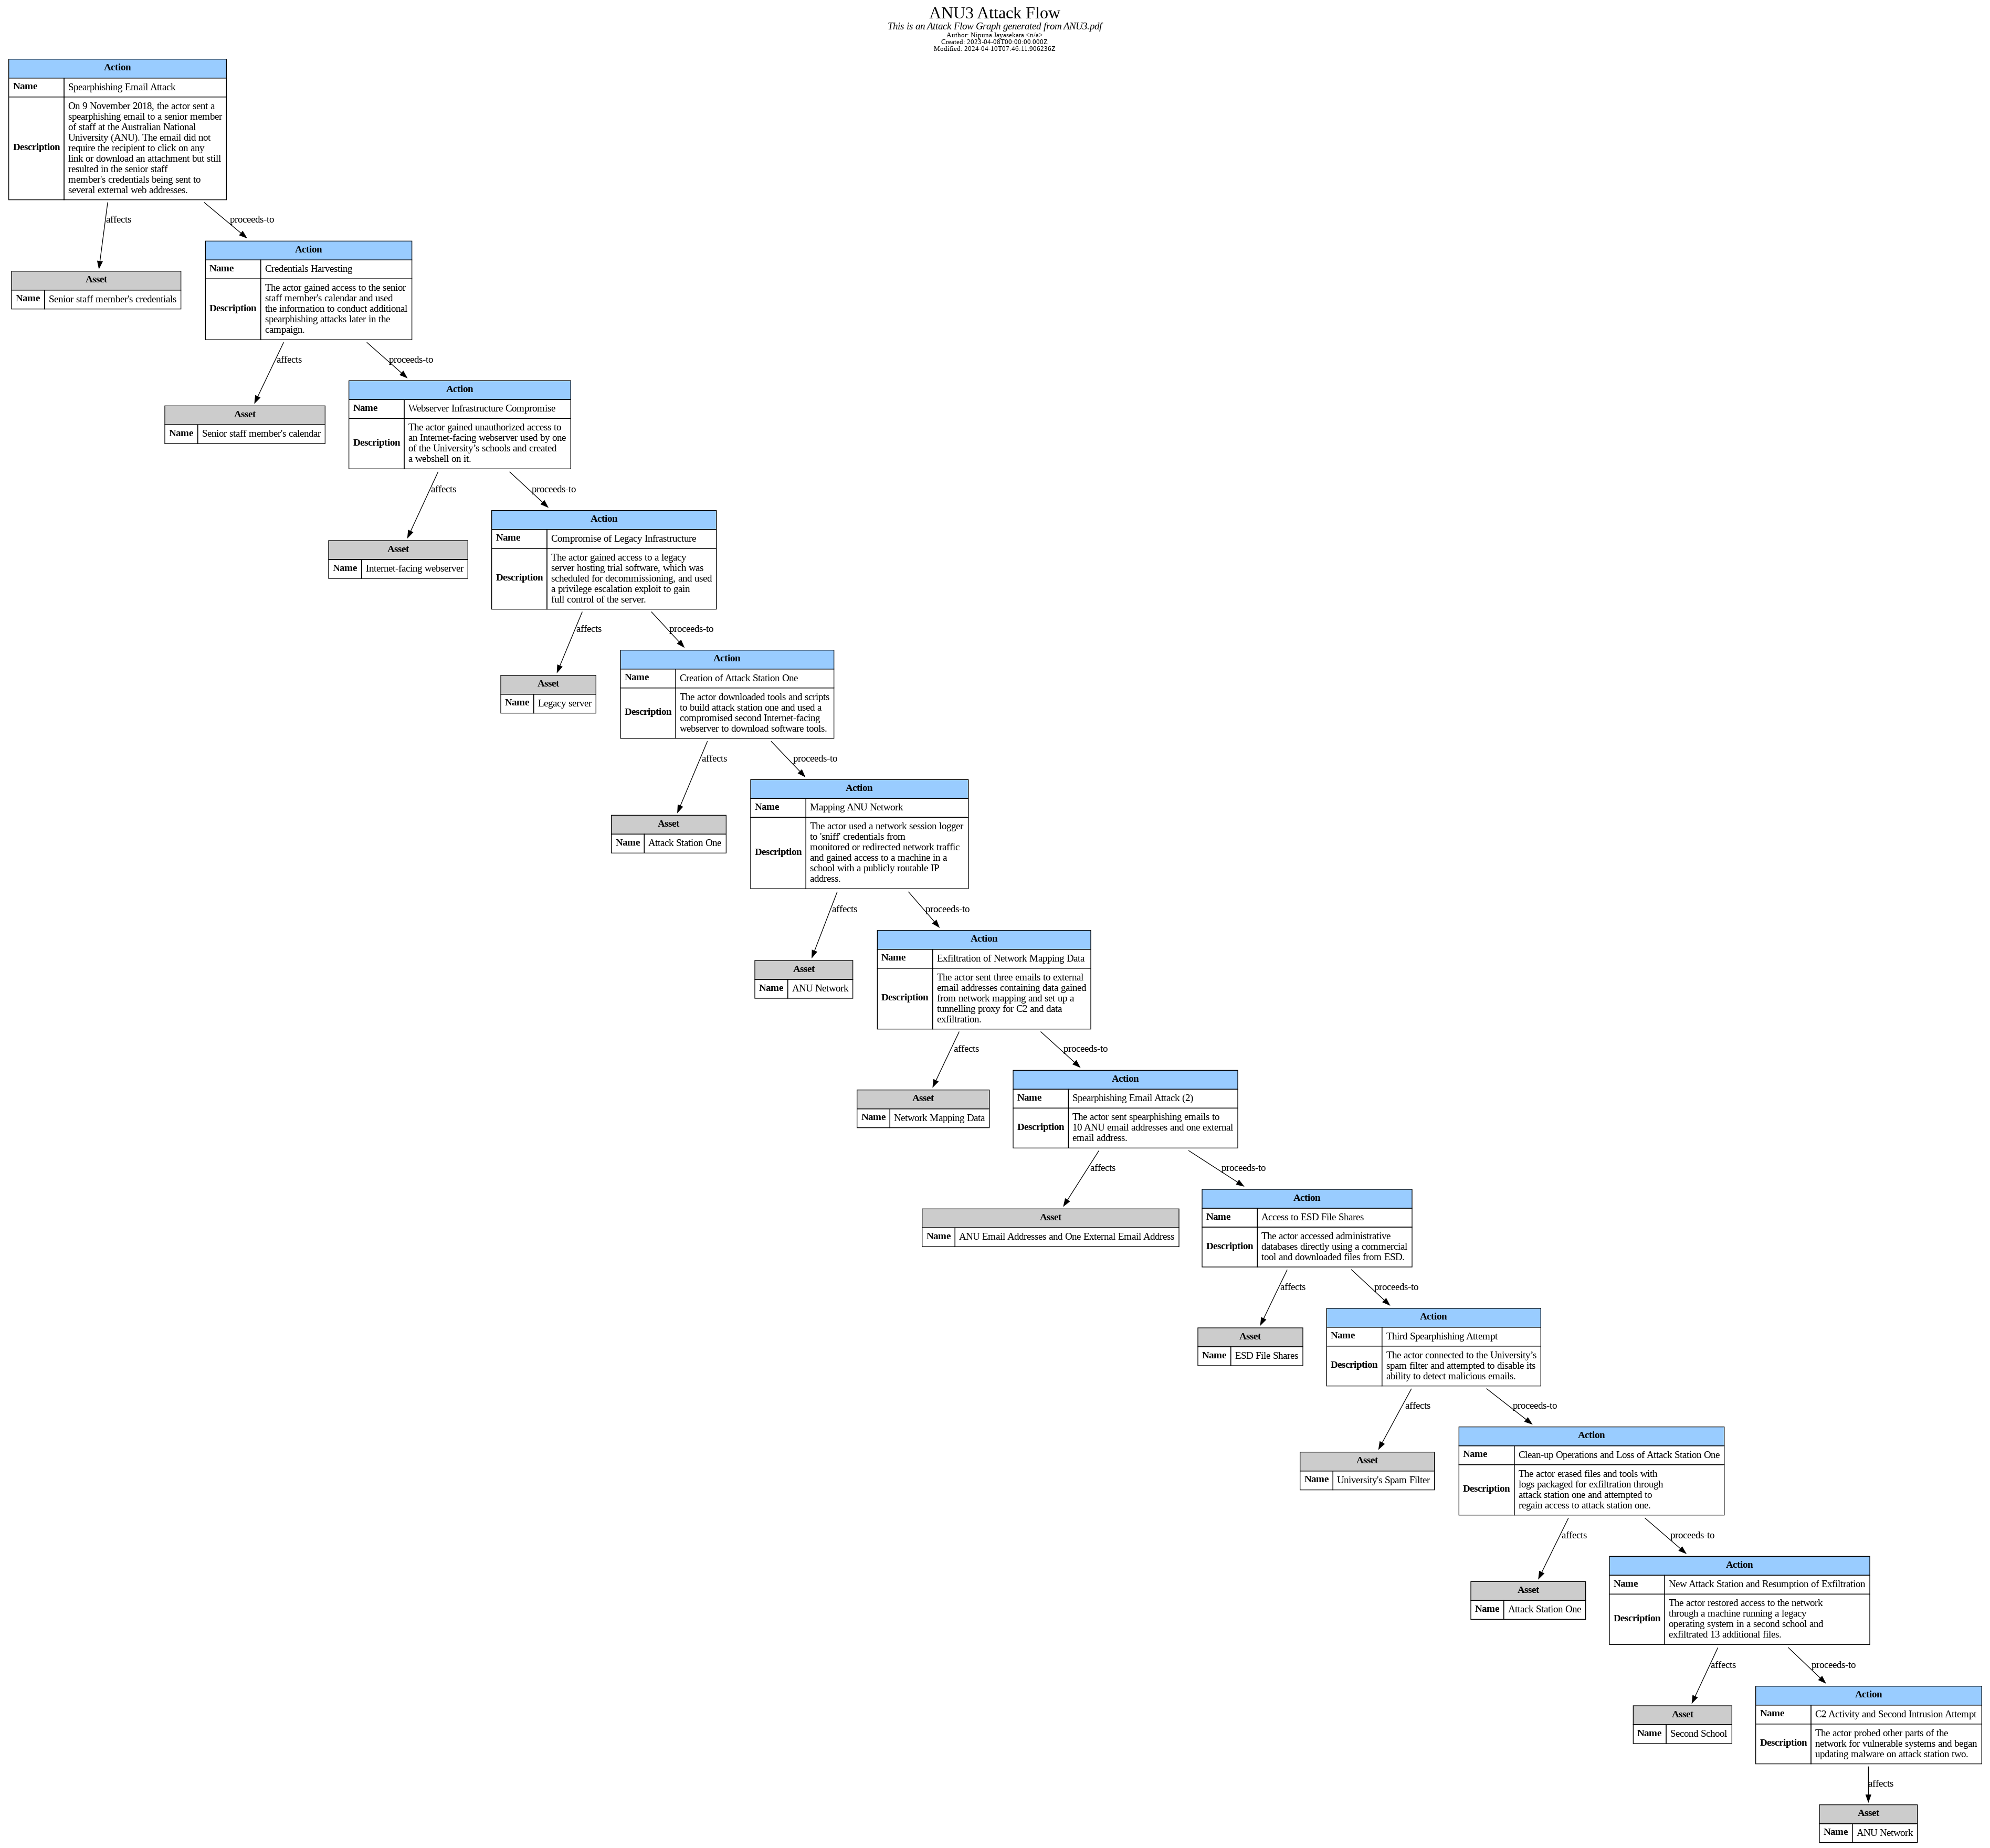

In [21]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

## Run \#2 - CISA AA22-138B VMWare Workspace (Alt)

### Document Upload

In [27]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Files processed and stored.


### Answer,Graph Generation and Misc.

In [28]:
doc_processor.display_processed_texts()

Document: CISA AA22-138B VMWare Workspace (Alt).docx
Word Count: 2247
Content: This Cybersecurity Advisory (CSA) has been updated with additional indicators of compromise (IOCs) a...
----------------------------------------------------------------------------------------------------


In [29]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [30]:
p2 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p2)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [31]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 182 seconds
[
    {
        "action_name": "Exploit Vulnerability (CVE-2022-22954)",
        "tactic_id": "TA0001",
        "technique_id": "T1203",
        "sub_technique_id": null,
        "evidence": "TA1 exploited CVE 2022-22954 to download a malicious shell script from https://20.232.97[.]189/up/80b6ae2cea.sh",
        "affected_assets": [
            "VMware Workspace ONE Access"
        ],
        "exploited_vulnerability": "CVE-2022-22954",
        "proceeding_actions": [
            "Run Shell Script"
        ]
    },
    {
        "action_name": "Run Shell Script",
        "tactic_id": "TA0002",
        "technique_id": "T1059",
        "sub_technique_id": null,
        "evidence": "The script was executed with the SUDO command",
        "affected_assets": [
            "VMware Workspace ONE Access"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Data Exfiltration"
        ]
    },
    {
        "action_name": 

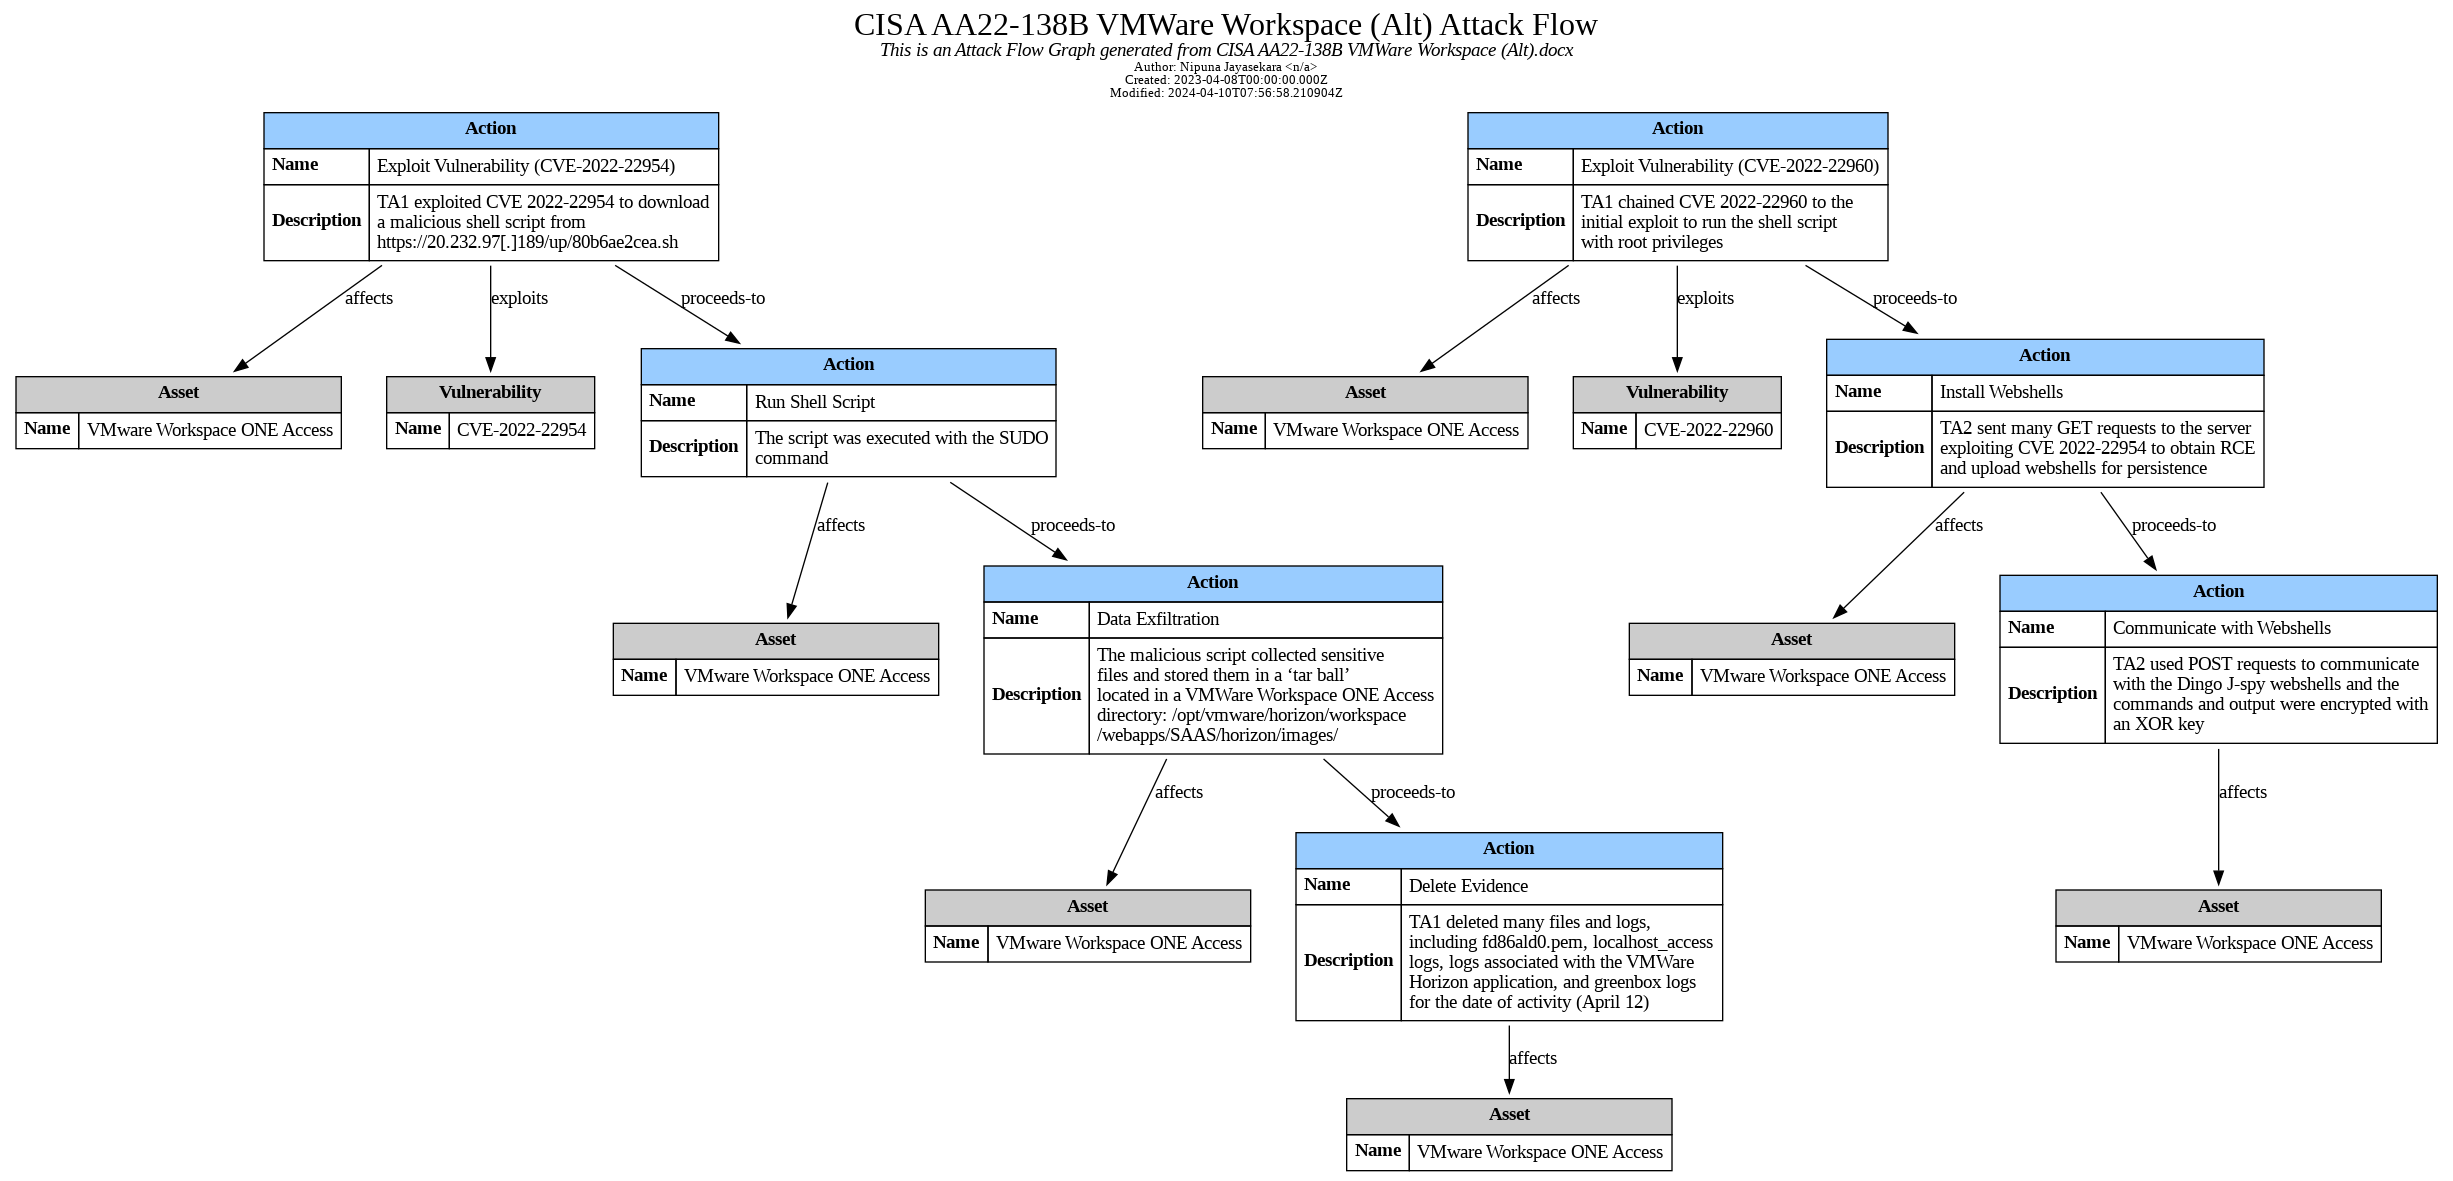

In [32]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [37]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/CISA%20AA22-138B%20VMWare%20Workspace%20%28Alt%29.json
Accuracy: 50.00%


## Run \#3 - CISA Iranian APT

### Document Upload

In [39]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Files processed and stored.


### Answer,Graph Generation and Misc.

In [40]:
doc_processor.display_processed_texts()

Document: CISA Iranian APT.docx
Word Count: 1242
Content: Summary From mid-June through mid-July 2022, CISA conducted an incident response engagement at a Fed...
----------------------------------------------------------------------------------------------------


In [41]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [58]:
p3 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p3)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [59]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 232 seconds
[
    {
        "action_name": "Exploit Log4Shell Vulnerability",
        "tactic_id": "TA0001",
        "technique_id": "T1190",
        "sub_technique_id": null,
        "evidence": "exploited Log4Shell vulnerability (CVE-2021-44228) in VMware Horizon server and observed a connection to known malicious IP address 182.54.217[.]2",
        "affected_assets": [
            "VMware Horizon server"
        ],
        "exploited_vulnerability": "CVE-2021-44228",
        "proceeding_actions": [
            "Add Exclusion Rule to Windows Defender"
        ]
    },
    {
        "action_name": "Add Exclusion Rule to Windows Defender",
        "tactic_id": "TA04013",
        "technique_id": "T1562.001",
        "sub_technique_id": null,
        "evidence": "ran the following PowerShell command that added an exclusion rule to Windows Defender: powershell try{Add-MpPreference -ExclusionPath 'C:'; Write-Host 'added-exclusion'} catch {Write-Host 'adding-exclusion-fail

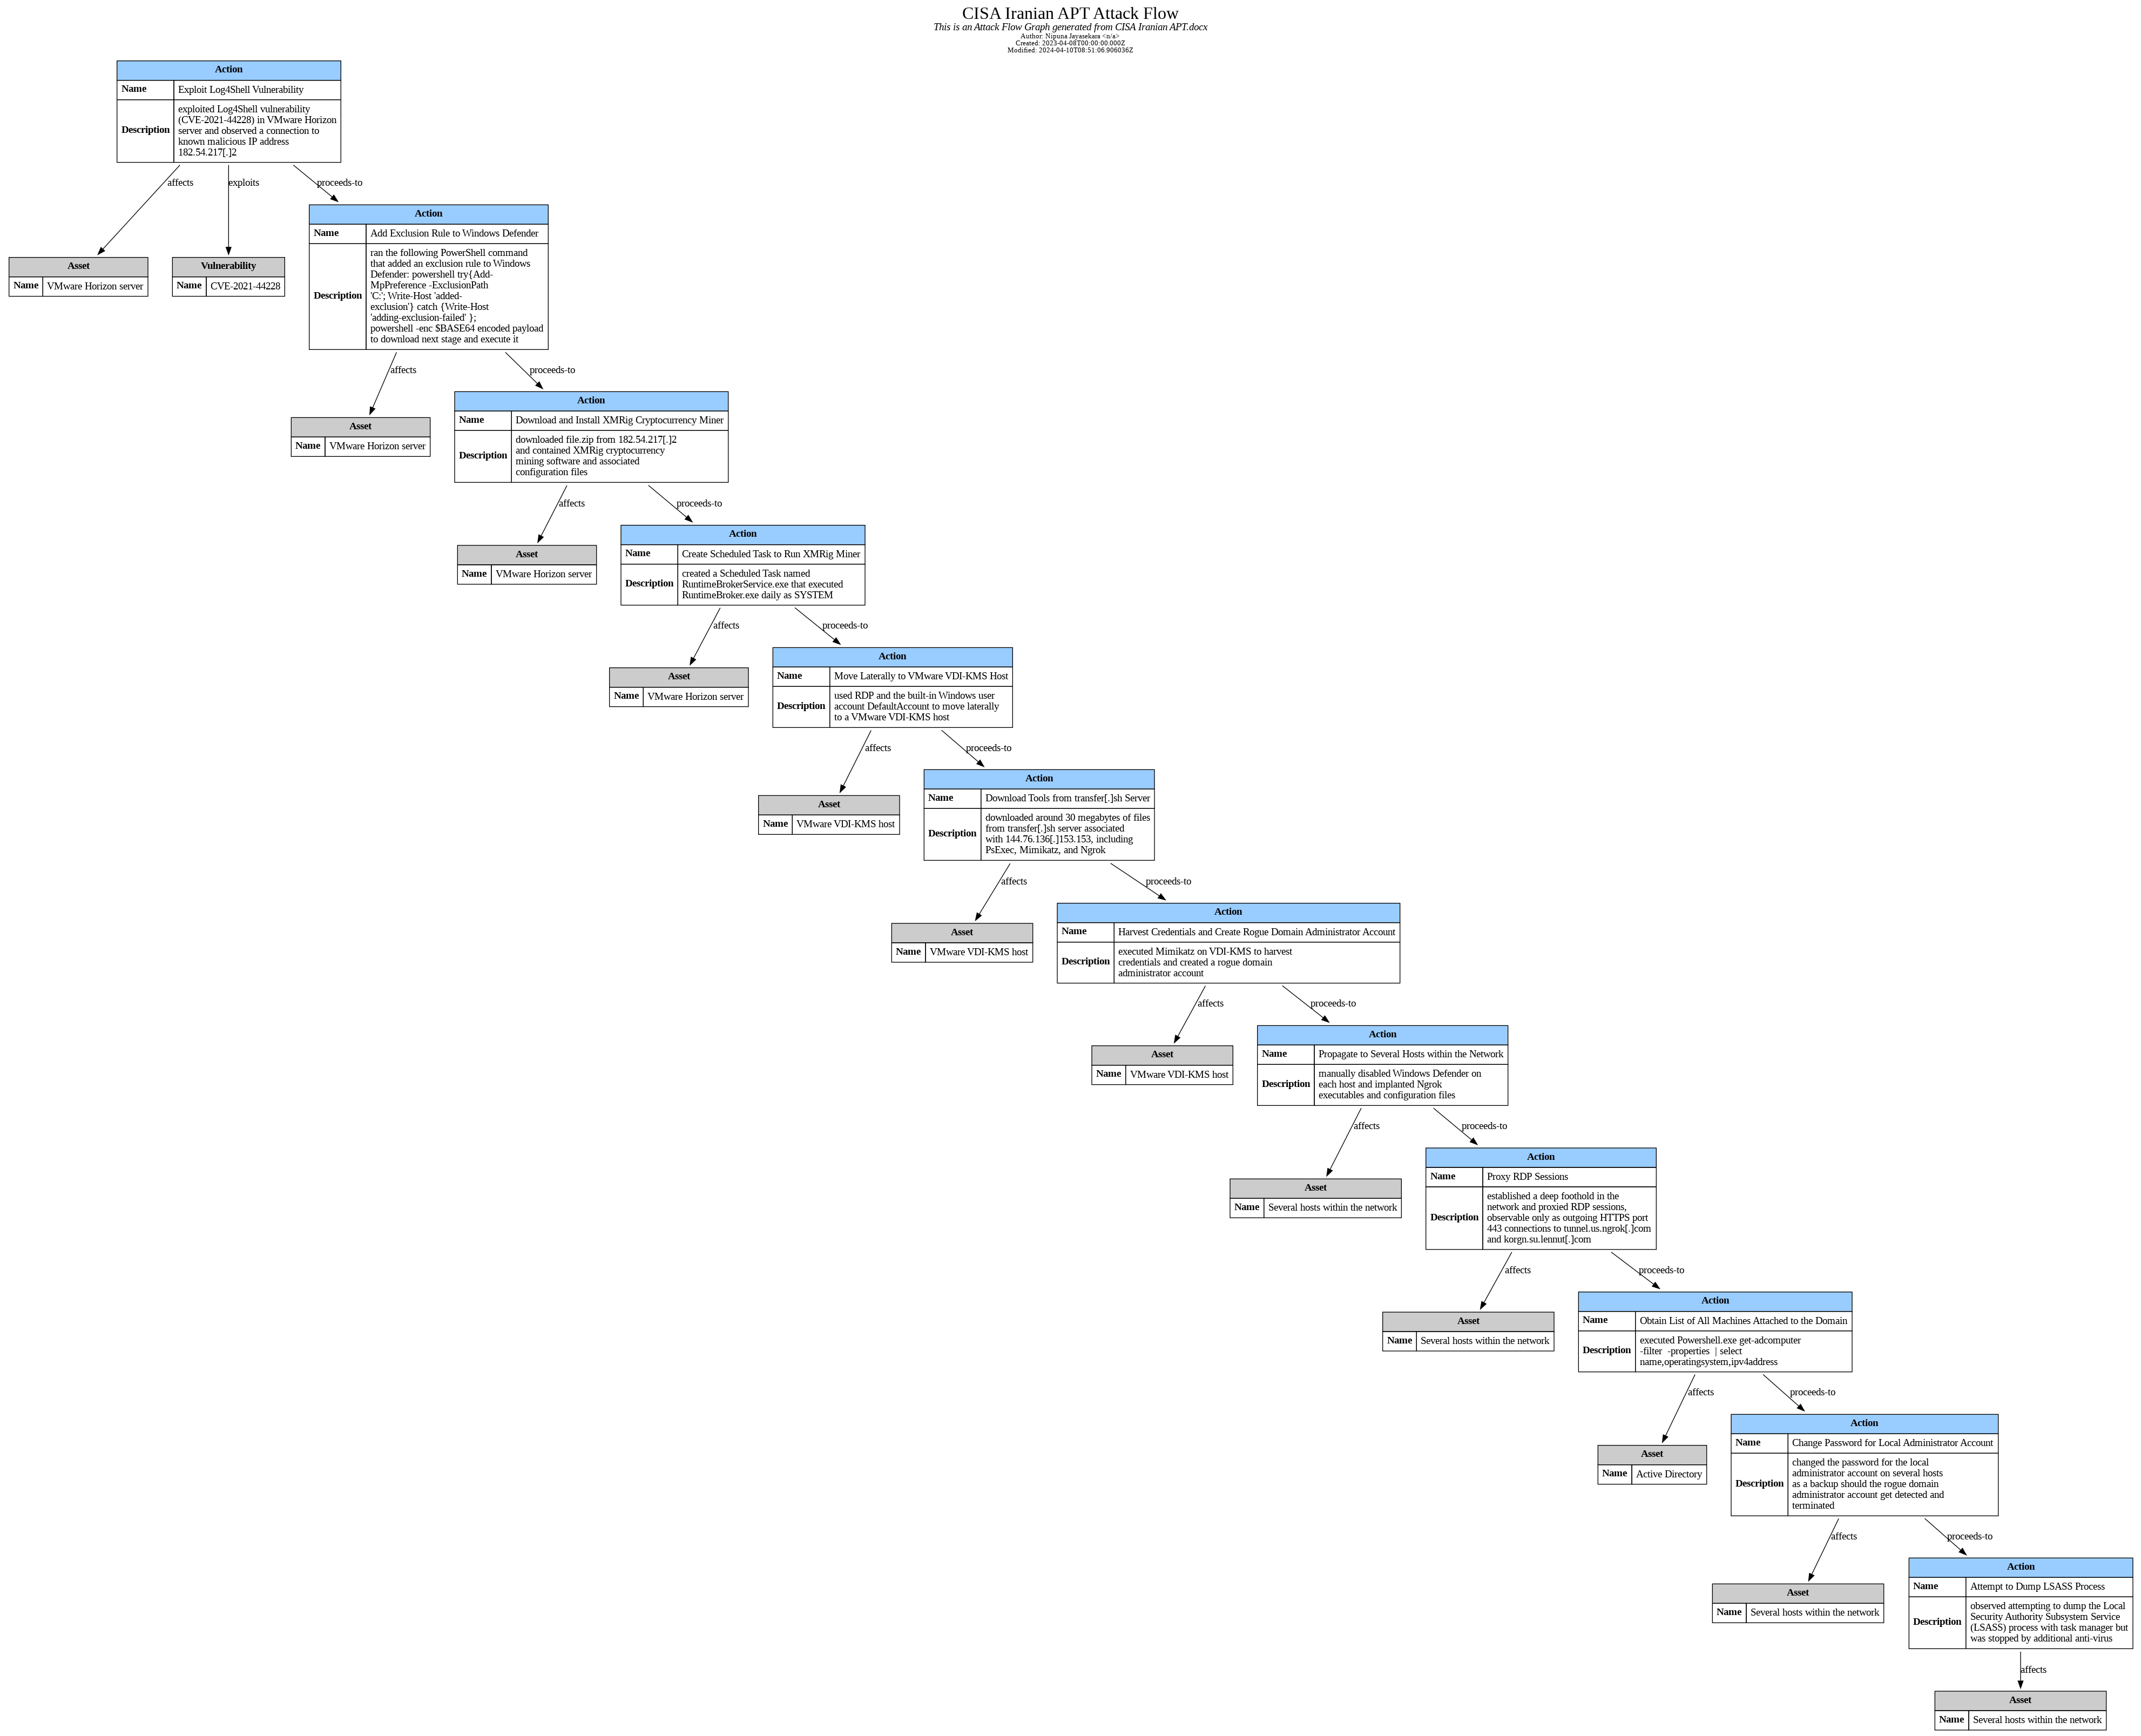

In [60]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [61]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/CISA%20Iranian%20APT.json
Accuracy: 62.50%


## Run \#4 - CobaltKitty

### Document Upload

In [62]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Files processed and stored.


### Answer,Graph Generation and Misc.

In [63]:
doc_processor.display_processed_texts()

Document: CobaltKitty.docx
Word Count: 1498
Content: HIGH-LEVEL ATTACK OUTLINE: A CAT-AND-MOUSE GAME IN FOUR ACTS The following sections outline the four...
----------------------------------------------------------------------------------------------------


In [64]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [65]:
p4 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p4)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [66]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 118 seconds
[
    {
        "action_name": "Social Engineering - Spear-phishing",
        "tactic_id": "TA0001",
        "technique_id": "T1192",
        "sub_technique_id": null,
        "evidence": "Carefully selected group of employees received spear-phishing emails, containing either links to malicious sites or weaponized Word documents.",
        "affected_assets": [
            "Employees"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Fileless Payload Delivery Infrastructure"
        ]
    },
    {
        "action_name": "Fileless Payload Delivery Infrastructure",
        "tactic_id": "TA0001",
        "technique_id": "T1055",
        "sub_technique_id": "T1055.001",
        "evidence": "The attackers dropped Visual Basic and PowerShell scripts in folders they created under the ProgramData, created persistence using Windows\u2019 registry, services, and scheduled tasks.",
        "affected_assets": [
           

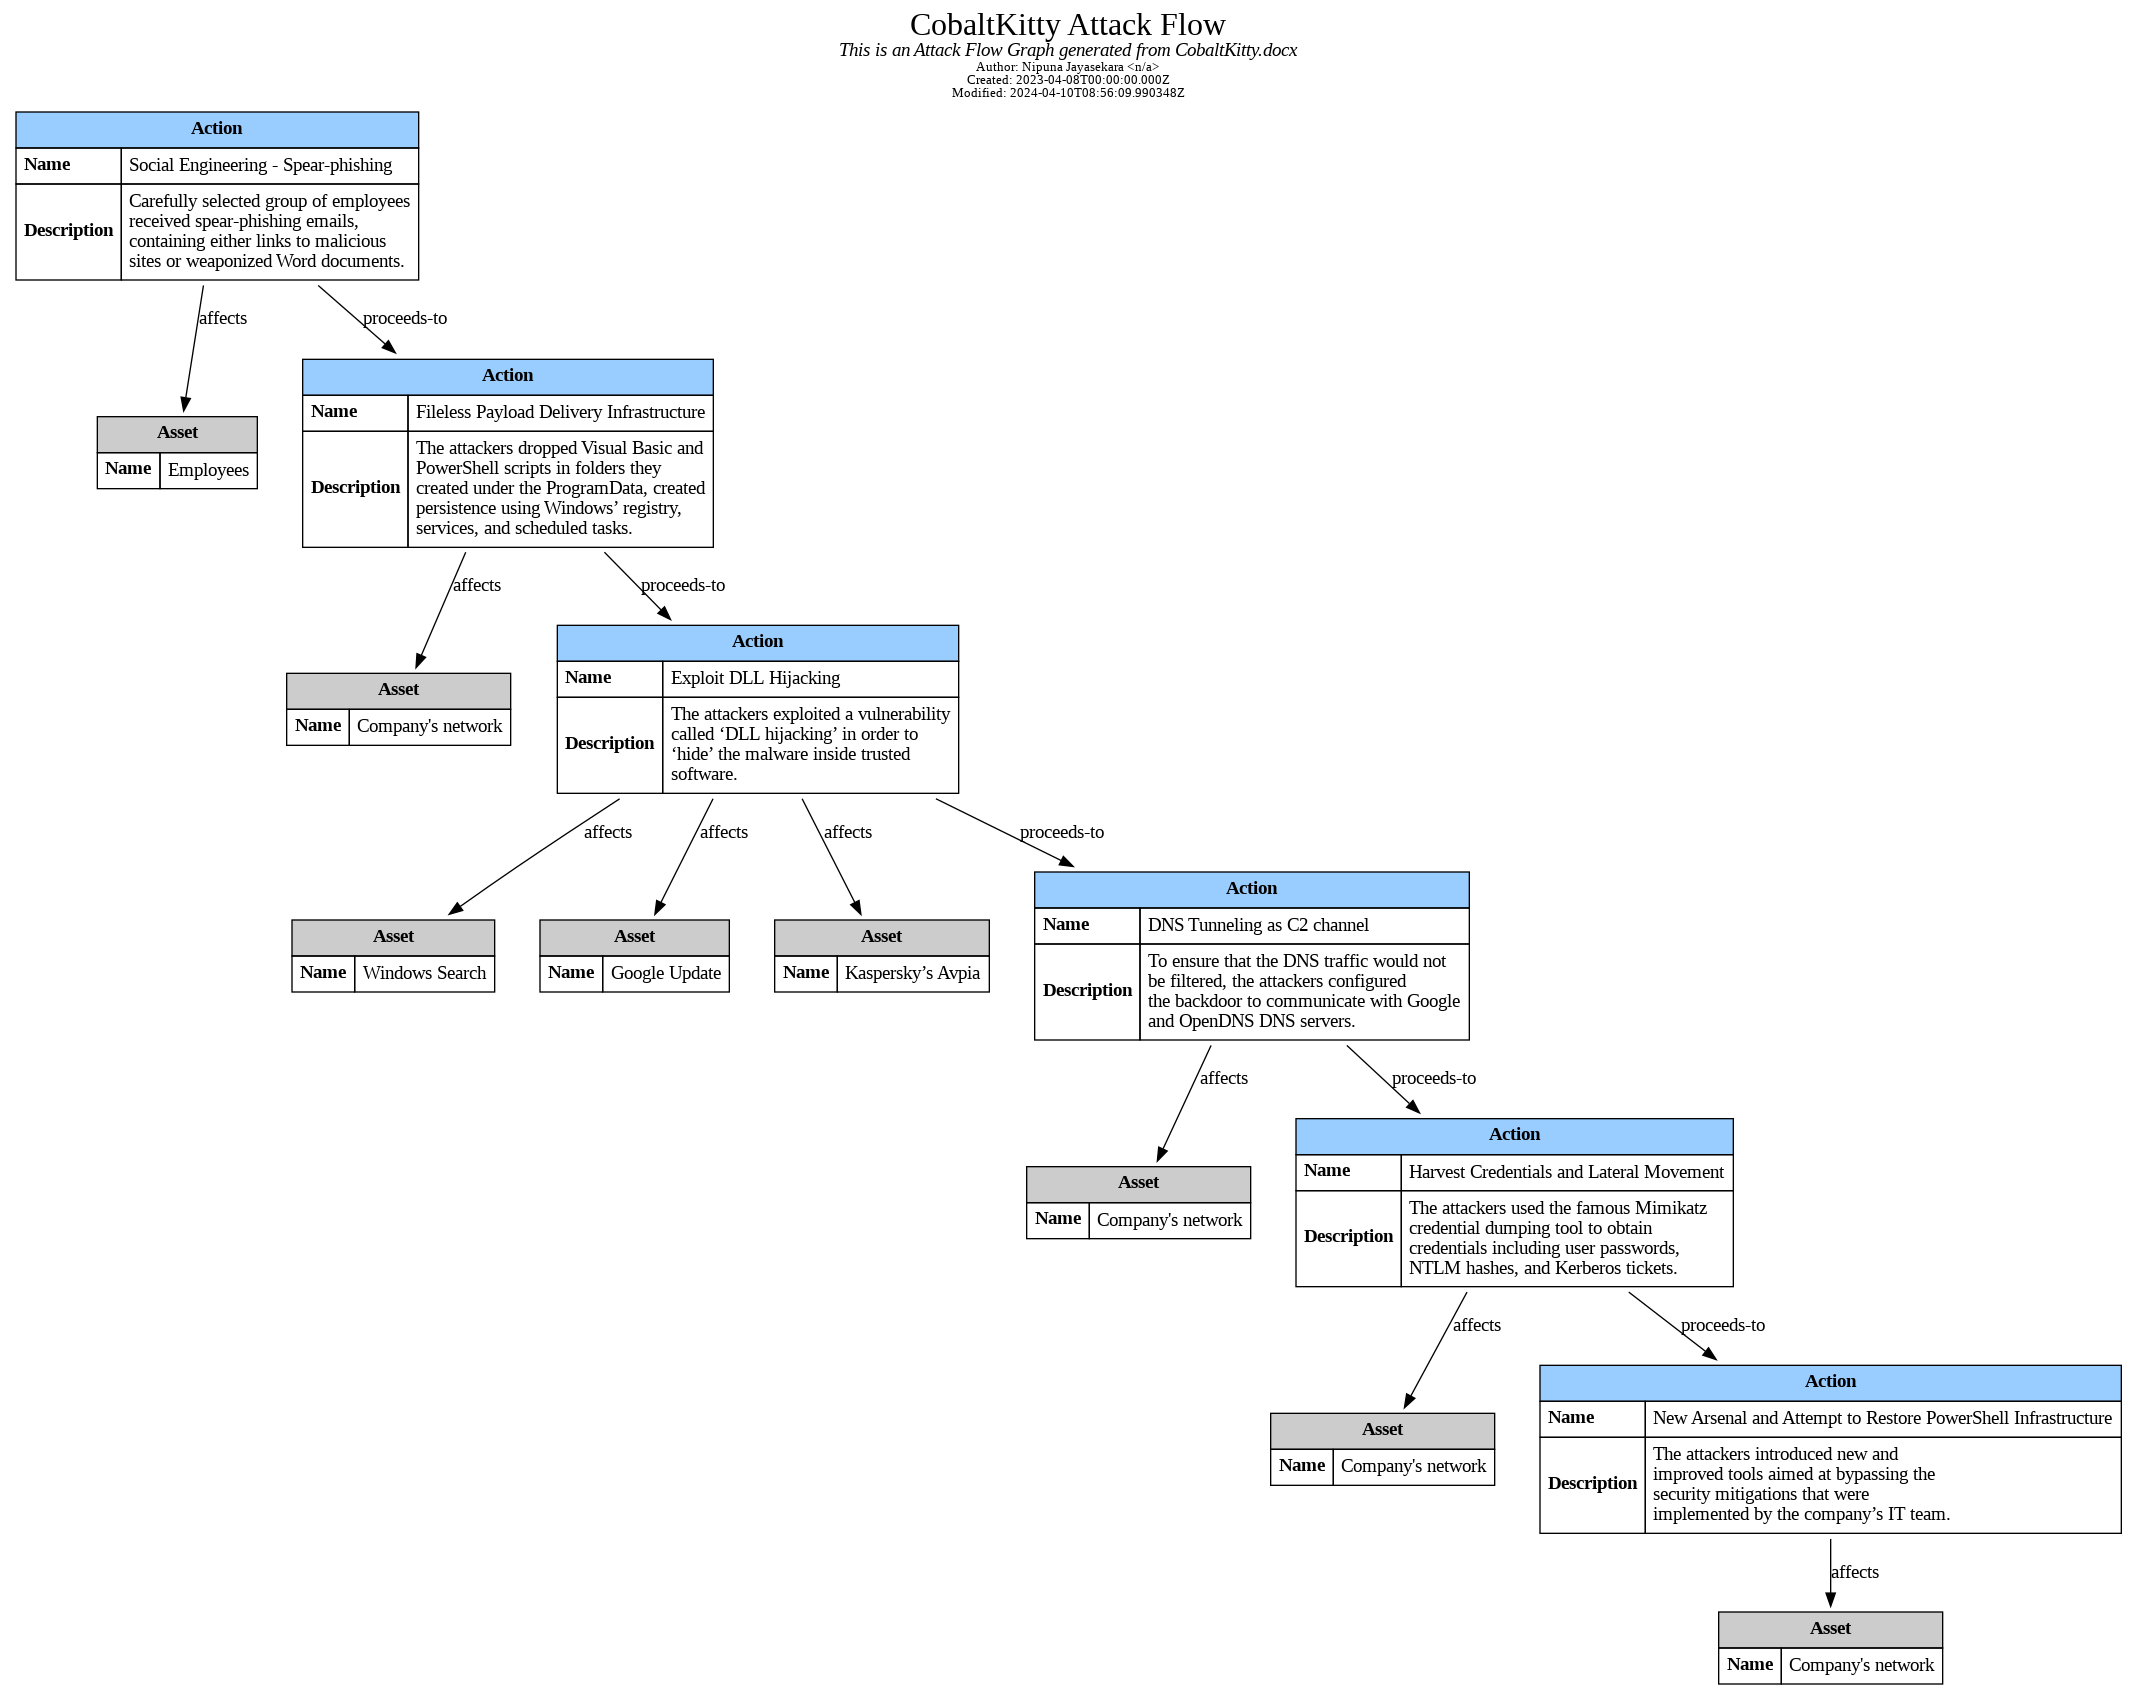

In [67]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [68]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/Cobalt%20Kitty%20Campaign.json
Accuracy: 0.00%


## Run \#5 - Conti Ransomeware

### Document Upload

In [69]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Files processed and stored.


### Answer,Graph Generation and Misc.

In [70]:
doc_processor.display_processed_texts()

Document: Conti Ransomware.docx
Word Count: 536
Content: First seen in May 2020, Conti ransomware has quickly become one of the most common ransomware varian...
----------------------------------------------------------------------------------------------------


In [71]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [72]:
p5 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p5)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [73]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 138 seconds
[
    {
        "action_name": "Phishing Campaign",
        "tactic_id": "TA0001",
        "technique_id": "T1566",
        "sub_technique_id": "T1566.002",
        "evidence": "The initial vector used by the threat actor was a zip file, which included a malicious JavaScript file, delivered through a phishing campaign.",
        "affected_assets": [
            "Network"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Initial Access"
        ]
    },
    {
        "action_name": "Initial Access",
        "tactic_id": "TA0001",
        "technique_id": "T1027",
        "sub_technique_id": null,
        "evidence": "The JavaScript file would eventually download and execute the IcedID malware.",
        "affected_assets": [
            "Targeted Systems"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Command and Control"
        ]
    },
    {
        "action_nam

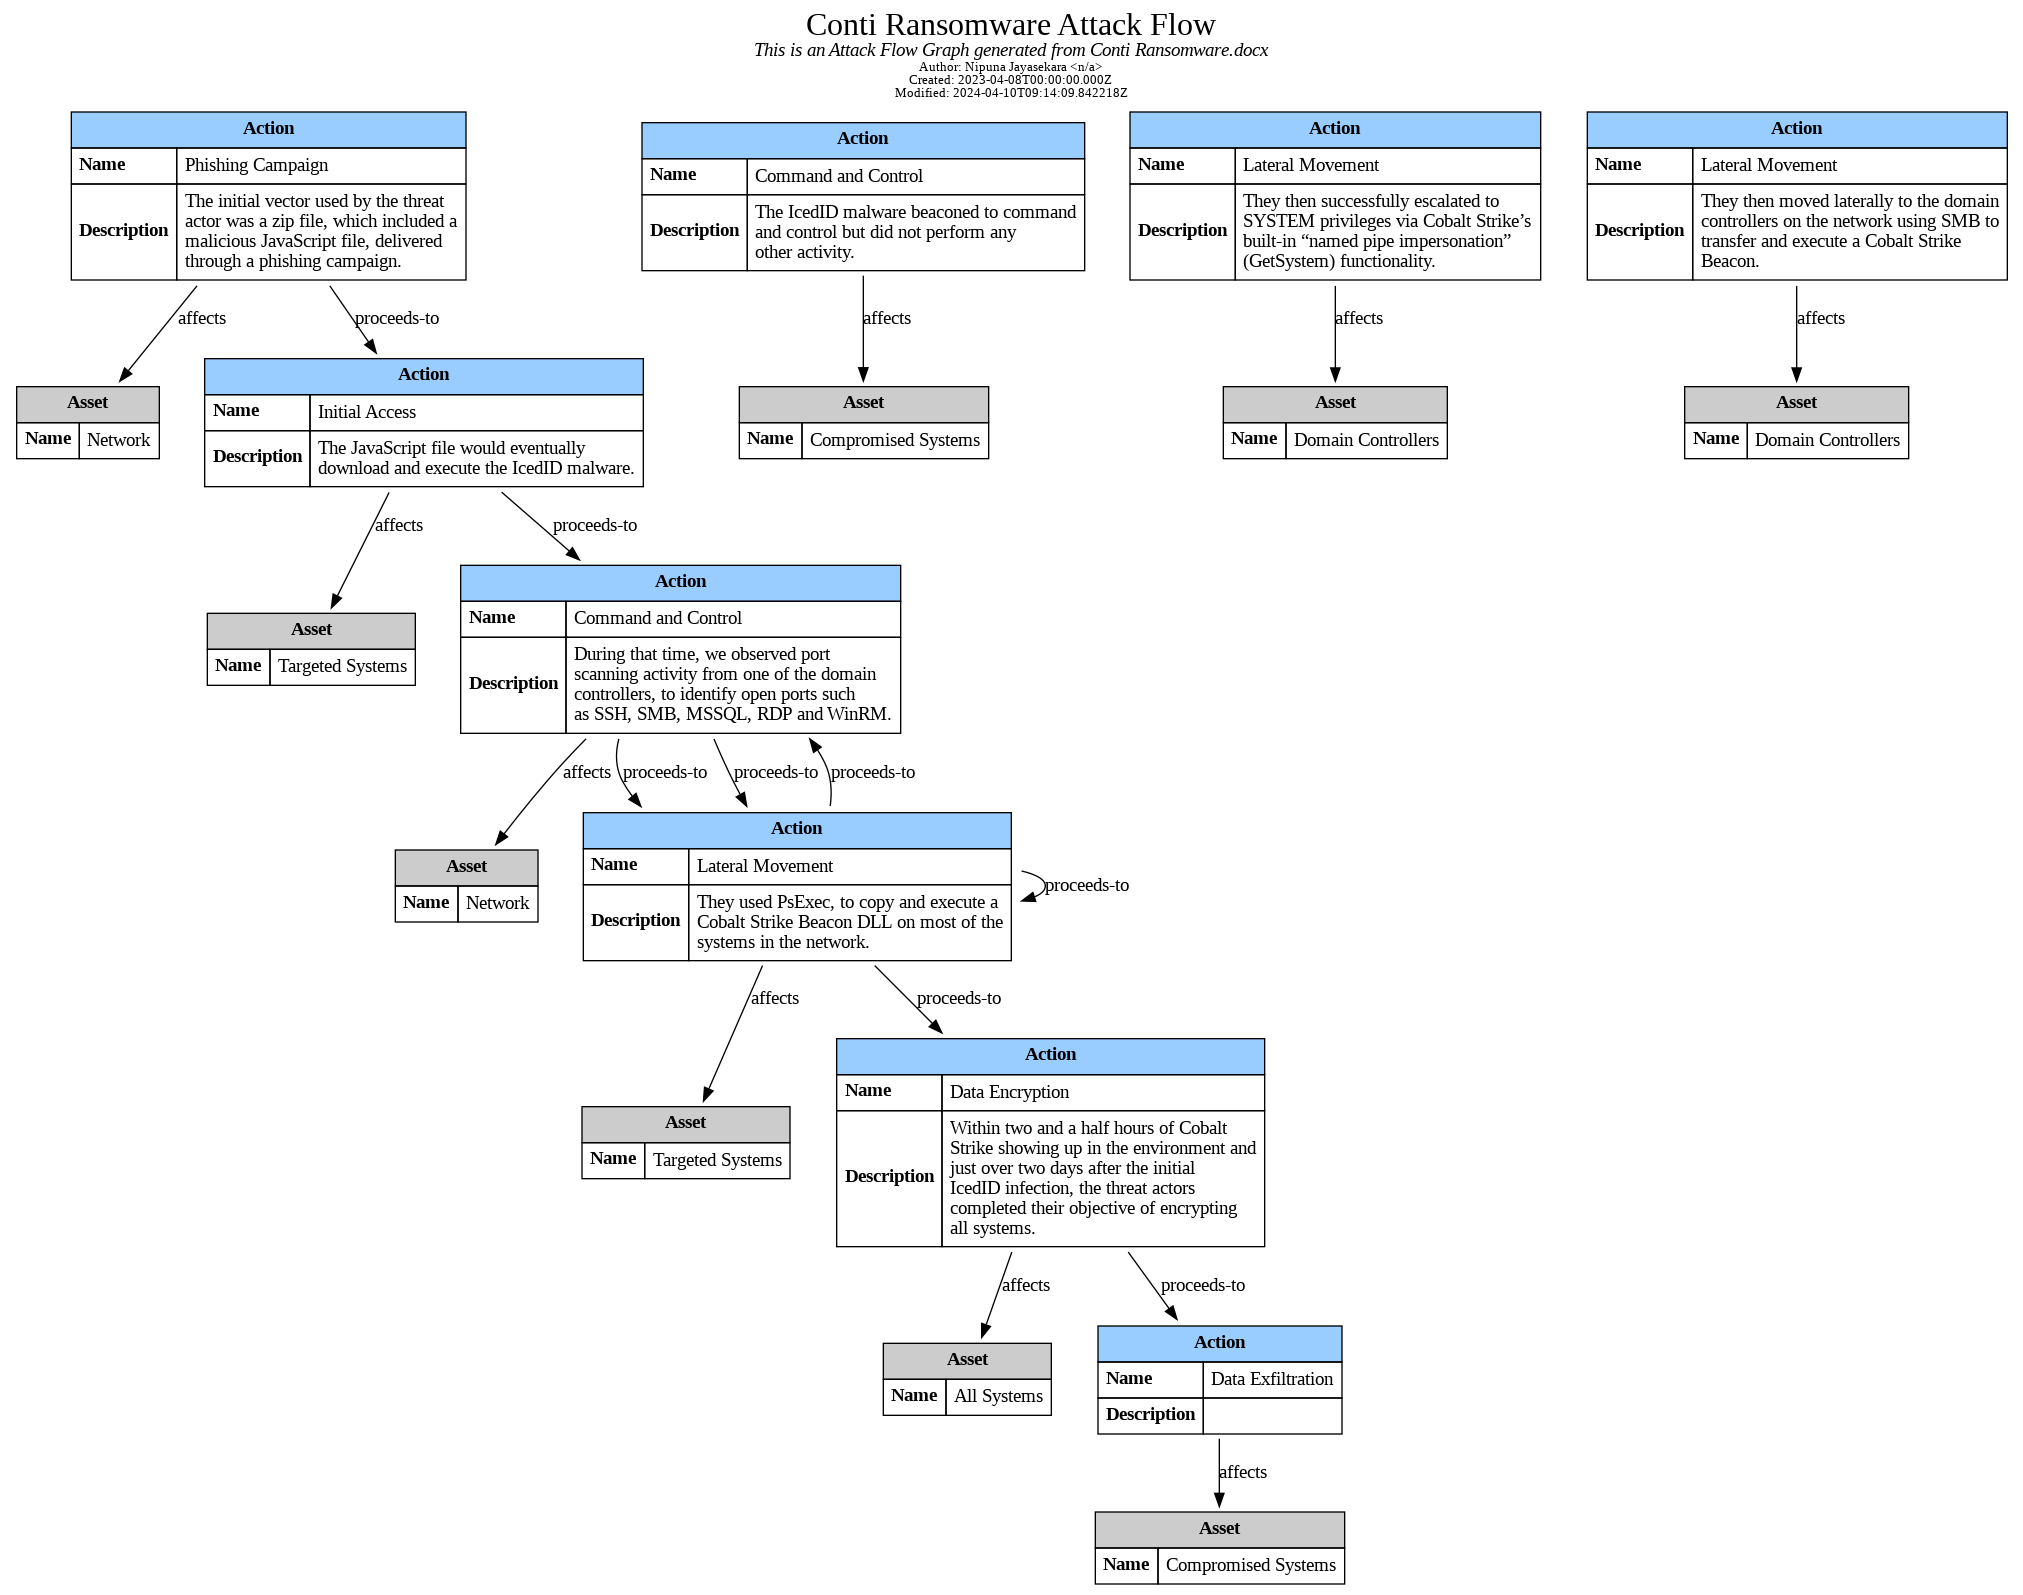

In [82]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [83]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/Conti%20Ransomware.json
Accuracy: 6.67%


## Run \#6 - DFIR - Bumblebee Round 2

### Document Upload

In [84]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Files processed and stored.


### Answer,Graph Generation and Misc.

In [85]:
doc_processor.display_processed_texts()

Document: DFIR - BumbleBee Round 2.docx
Word Count: 506
Content: In this intrusion from May 2022, the threat actors used BumbleBee as the initial access vector. Bumb...
----------------------------------------------------------------------------------------------------


In [86]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [88]:
p6 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p6)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [89]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 103 seconds
[
    {
        "action_name": "Initial Access (BumbleBee)",
        "tactic_id": "TA0001",
        "technique_id": "T1192",
        "sub_technique_id": "T1192.001",
        "evidence": "The intrusion began with the delivery of an ISO file containing a LNK file and a BumbleBee payload in the form of a hidden DLL file.",
        "affected_assets": [
            "Workstation"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Command and Control",
            "Reconnaissance"
        ]
    },
    {
        "action_name": "Command and Control (Cobalt Strike)",
        "tactic_id": "TA0002",
        "technique_id": "T1055",
        "sub_technique_id": "T1055.001",
        "evidence": "A new process was created that was then used to host a Cobalt Strike beacon.",
        "affected_assets": [
            "Compromised Workstation"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
    

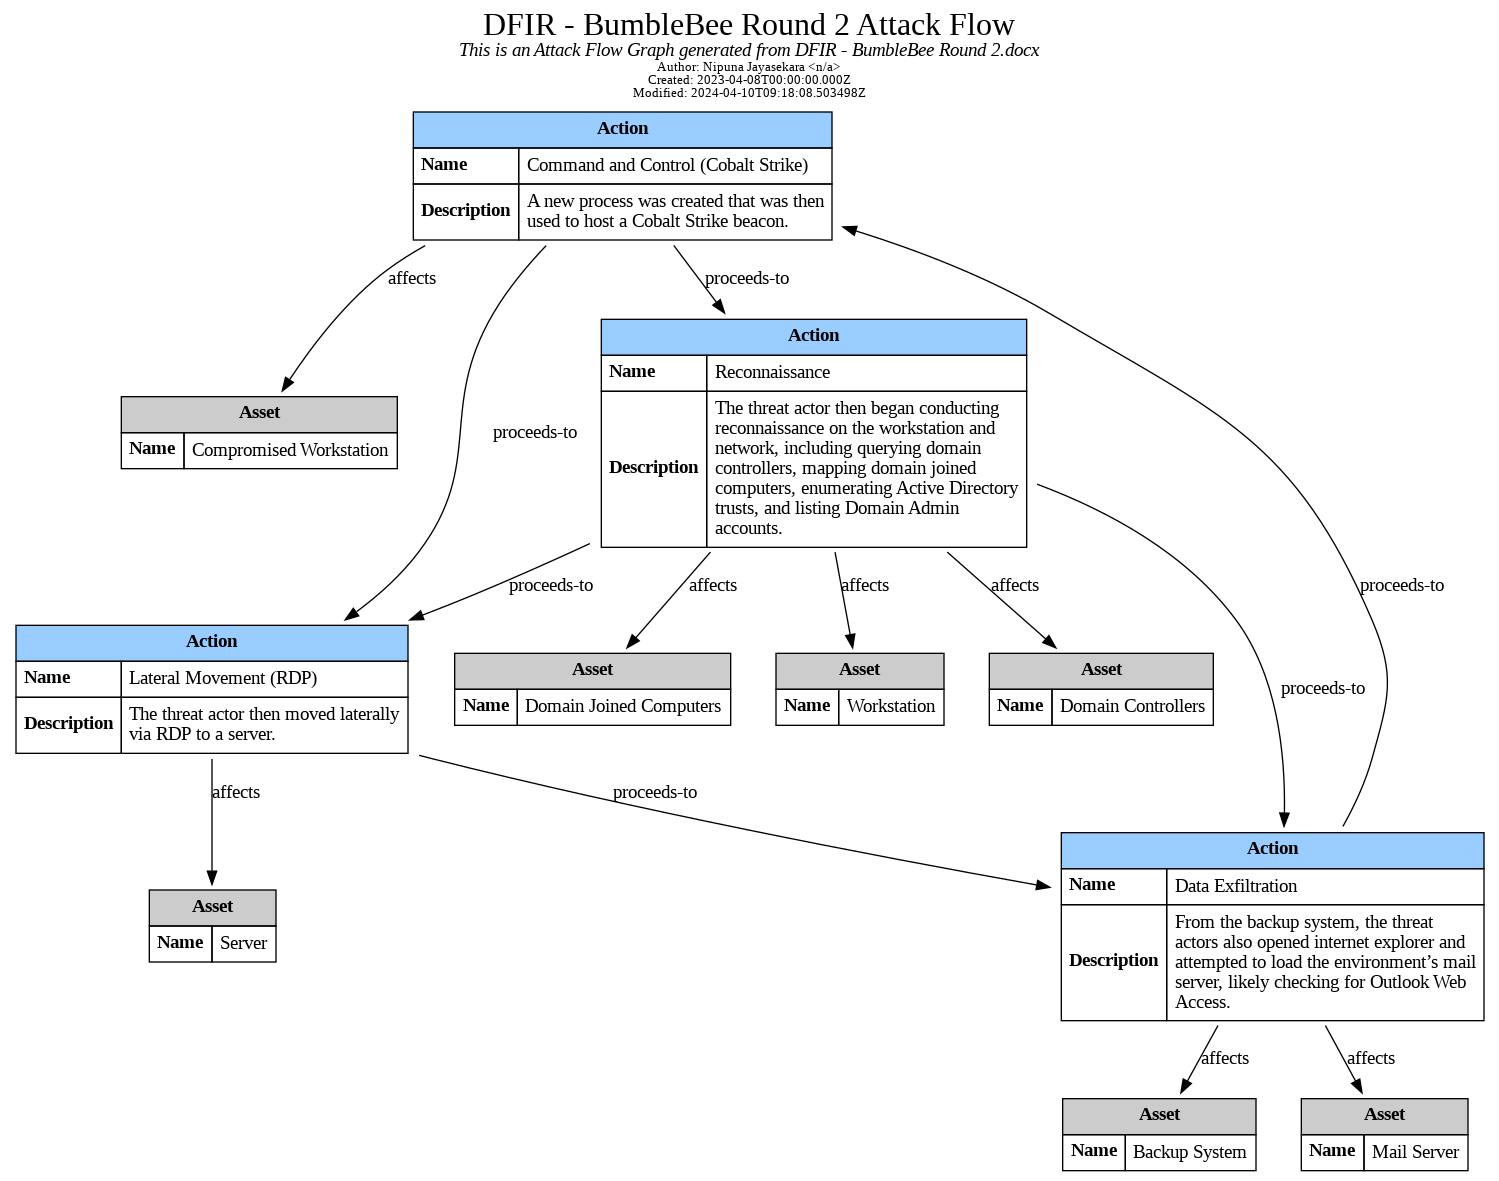

In [90]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [91]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/DFIR%20-%20BumbleBee%20Round%202.json
Accuracy: 6.67%


## Run \#7 - Equifax

### Document Upload

In [99]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Pages 1 to 7 will be excluded.
Pages 13 to 96 will be excluded.
Files processed and stored.


### Answer,Graph Generation and Misc.

In [100]:
doc_processor.display_processed_texts()

Document: Equifax-Report.pdf
Word Count: 1404
Content: Timeline of Key Events March 7, 2017  Apache Struts Project Management Committee announces the CVE-...
----------------------------------------------------------------------------------------------------


In [101]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [102]:
p7 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p7)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [103]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 131 seconds
[
    {
        "action_name": "Vulnerability Exploitation",
        "tactic_id": "TA0002",
        "technique_id": "T1192",
        "sub_technique_id": null,
        "evidence": "On May 13, 2017, attackers entered the Equifax network through the Apache Struts vulnerability located within the Automated Consumer Interview System (ACIS) application and dropped web shells onto the Equifax system.",
        "affected_assets": [
            "Equifax network",
            "Automated Consumer Interview System (ACIS)"
        ],
        "exploited_vulnerability": "CVE-2017-5638",
        "proceeding_actions": [
            "Data Exfiltration"
        ]
    },
    {
        "action_name": "Data Exfiltration",
        "tactic_id": "TA0010",
        "technique_id": "T1003",
        "sub_technique_id": null,
        "evidence": "Approximately 9,000 queries were performed to sensitive databases within the Equifax system between May 13, 2017 and July 30, 2017.",
       

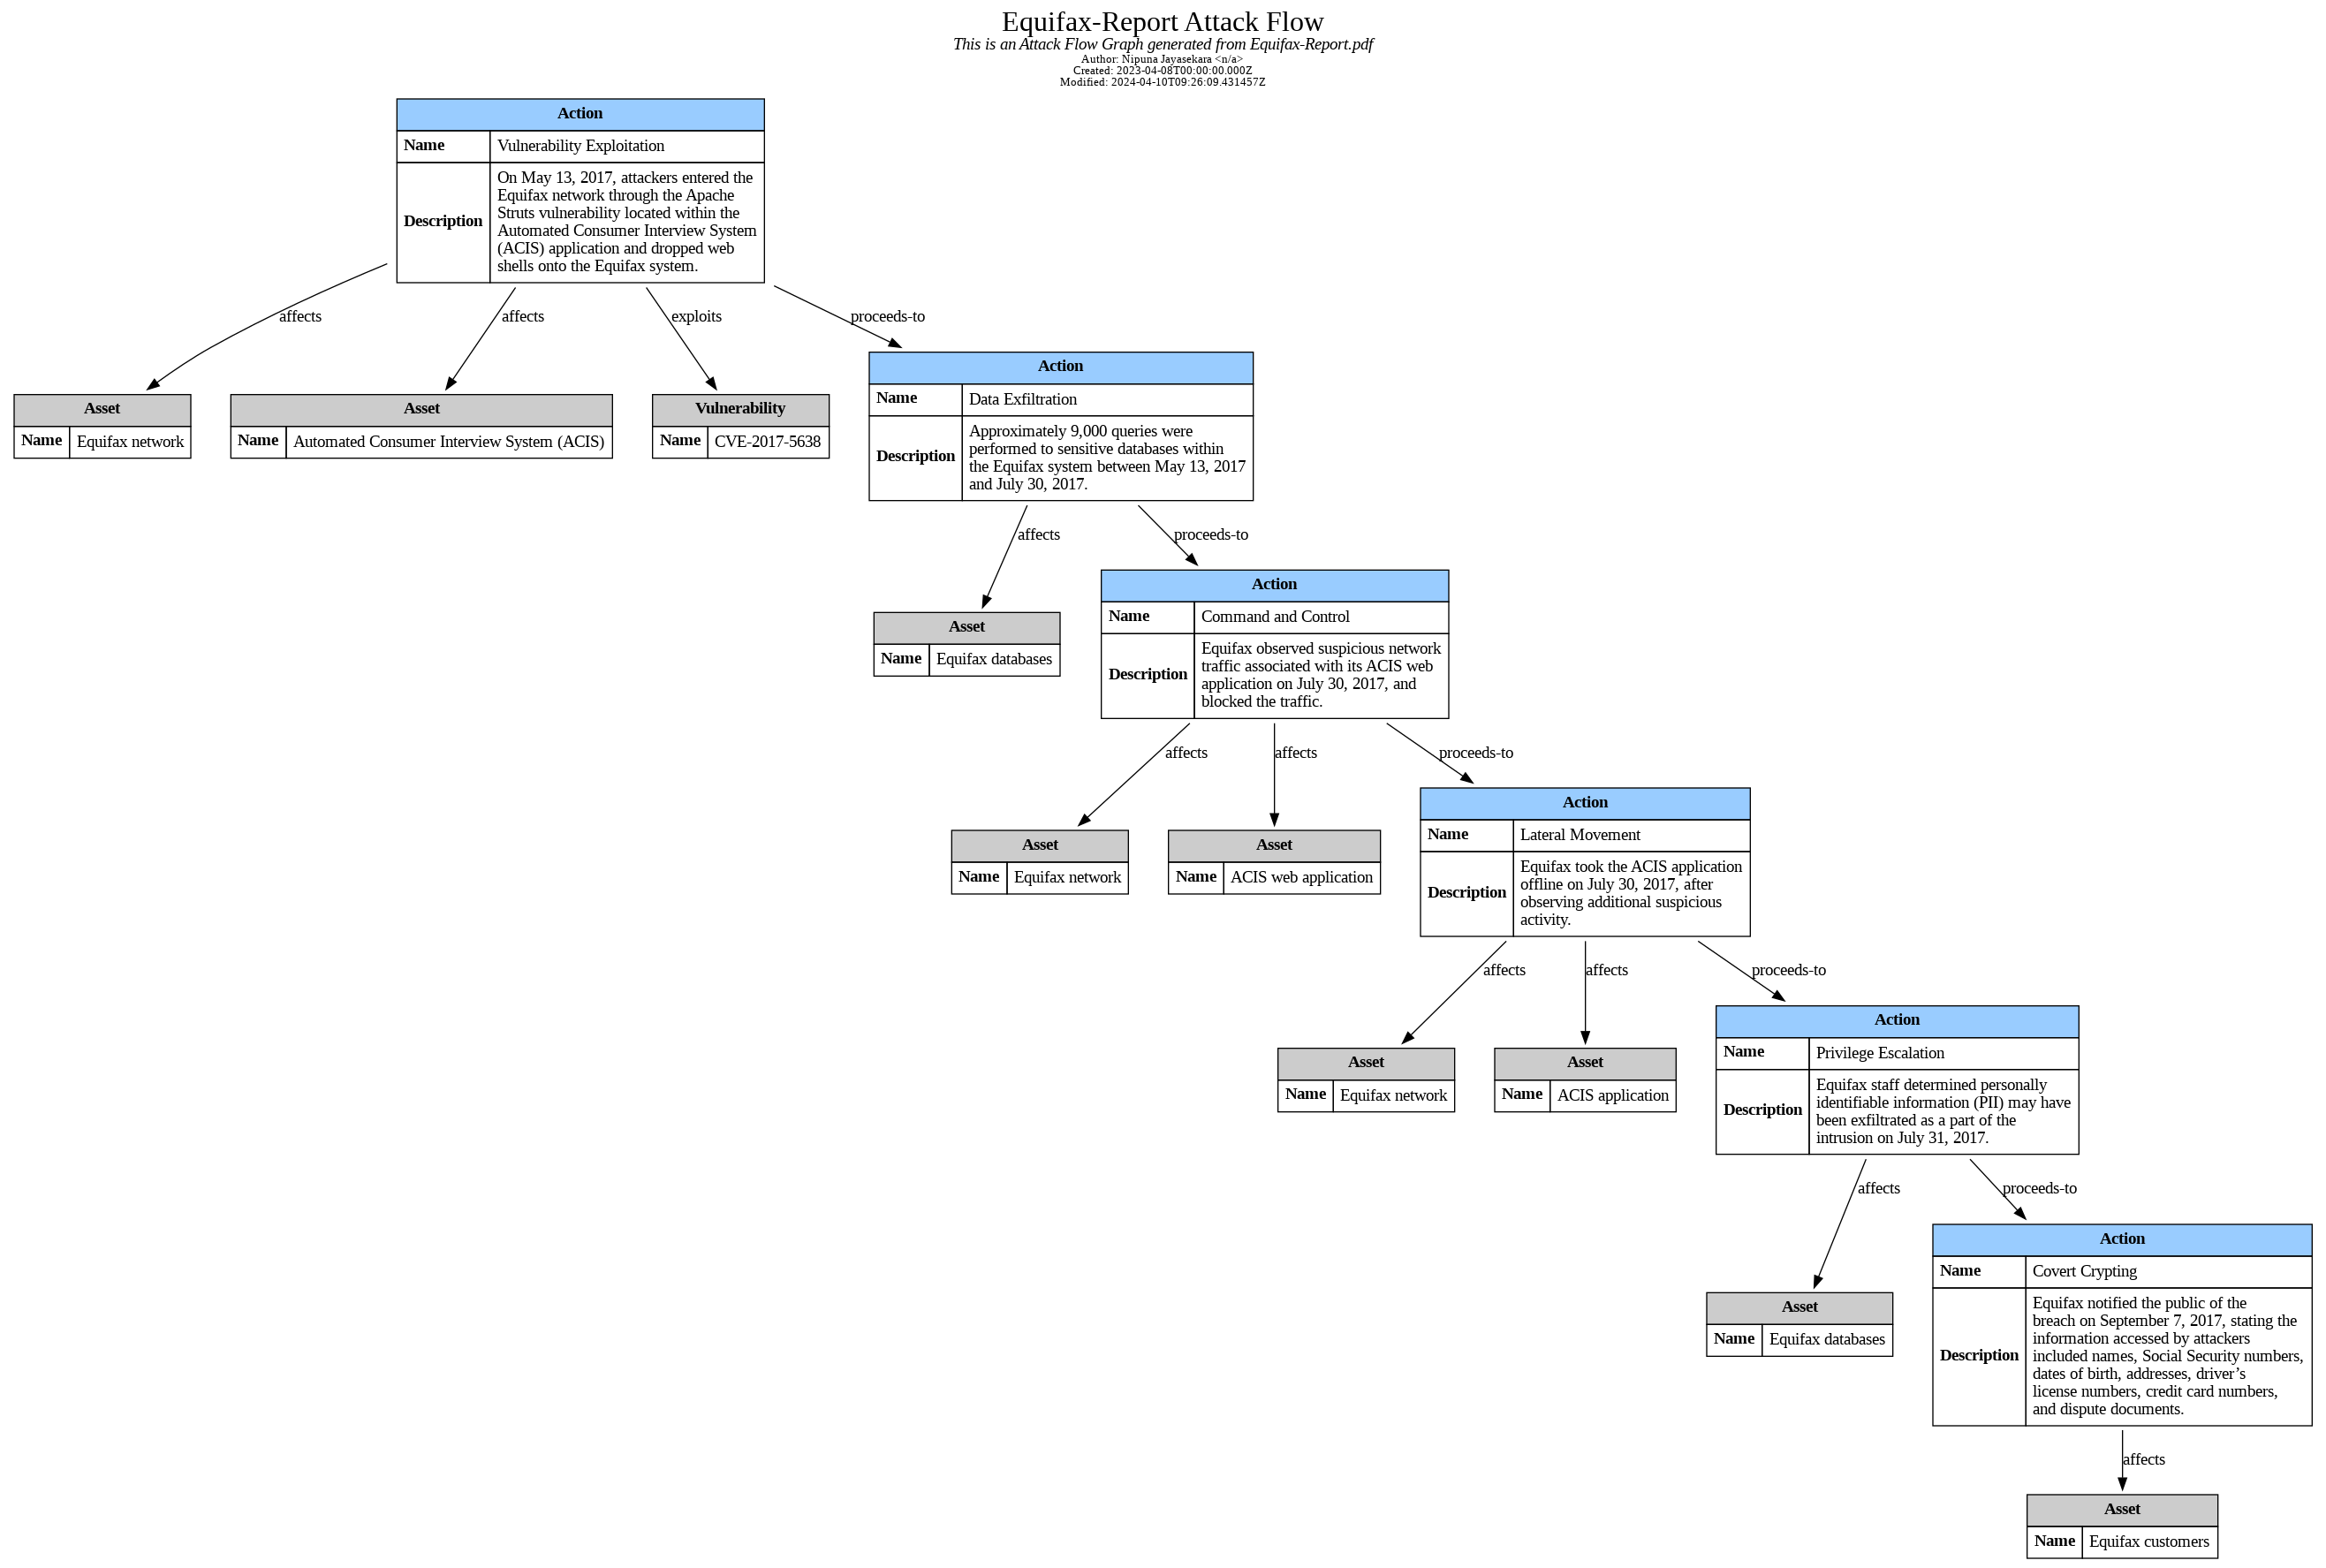

In [104]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [105]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/Equifax%20Breach.json
Accuracy: 0.00%


## Run \#8 - Gootloader

### Document Upload

In [106]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Files processed and stored.


### Answer,Graph Generation and Misc.

In [107]:
doc_processor.display_processed_texts()

Document: Gootloader.txt
Word Count: 356
Content: The intrusion started with a user searching Bing for “Olymplus Plea Agreement?”. The user then click...
----------------------------------------------------------------------------------------------------


In [108]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [109]:
p8 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p8)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [110]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 131 seconds
[
    {
        "action_name": "Initial Access",
        "tactic_id": "TA0001",
        "technique_id": "T1566.002",
        "sub_technique_id": null,
        "evidence": "A user searched Bing for \u2018Olymplus Plea Agreement?\u2019 and clicked on the second search result which led to the download and execution of a malicious javascript file.",
        "affected_assets": [
            "User's web browser"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Execution of Malware"
        ]
    },
    {
        "action_name": "Execution of Malware",
        "tactic_id": "TA0001",
        "technique_id": "T1055",
        "sub_technique_id": null,
        "evidence": "Gootloader utilized encoded PowerShell scripts to load Cobalt Strike into memory and persist on the host using a combination of registry keys and scheduled tasks.",
        "affected_assets": [
            "Compromised Host"
        ],
        "exploit

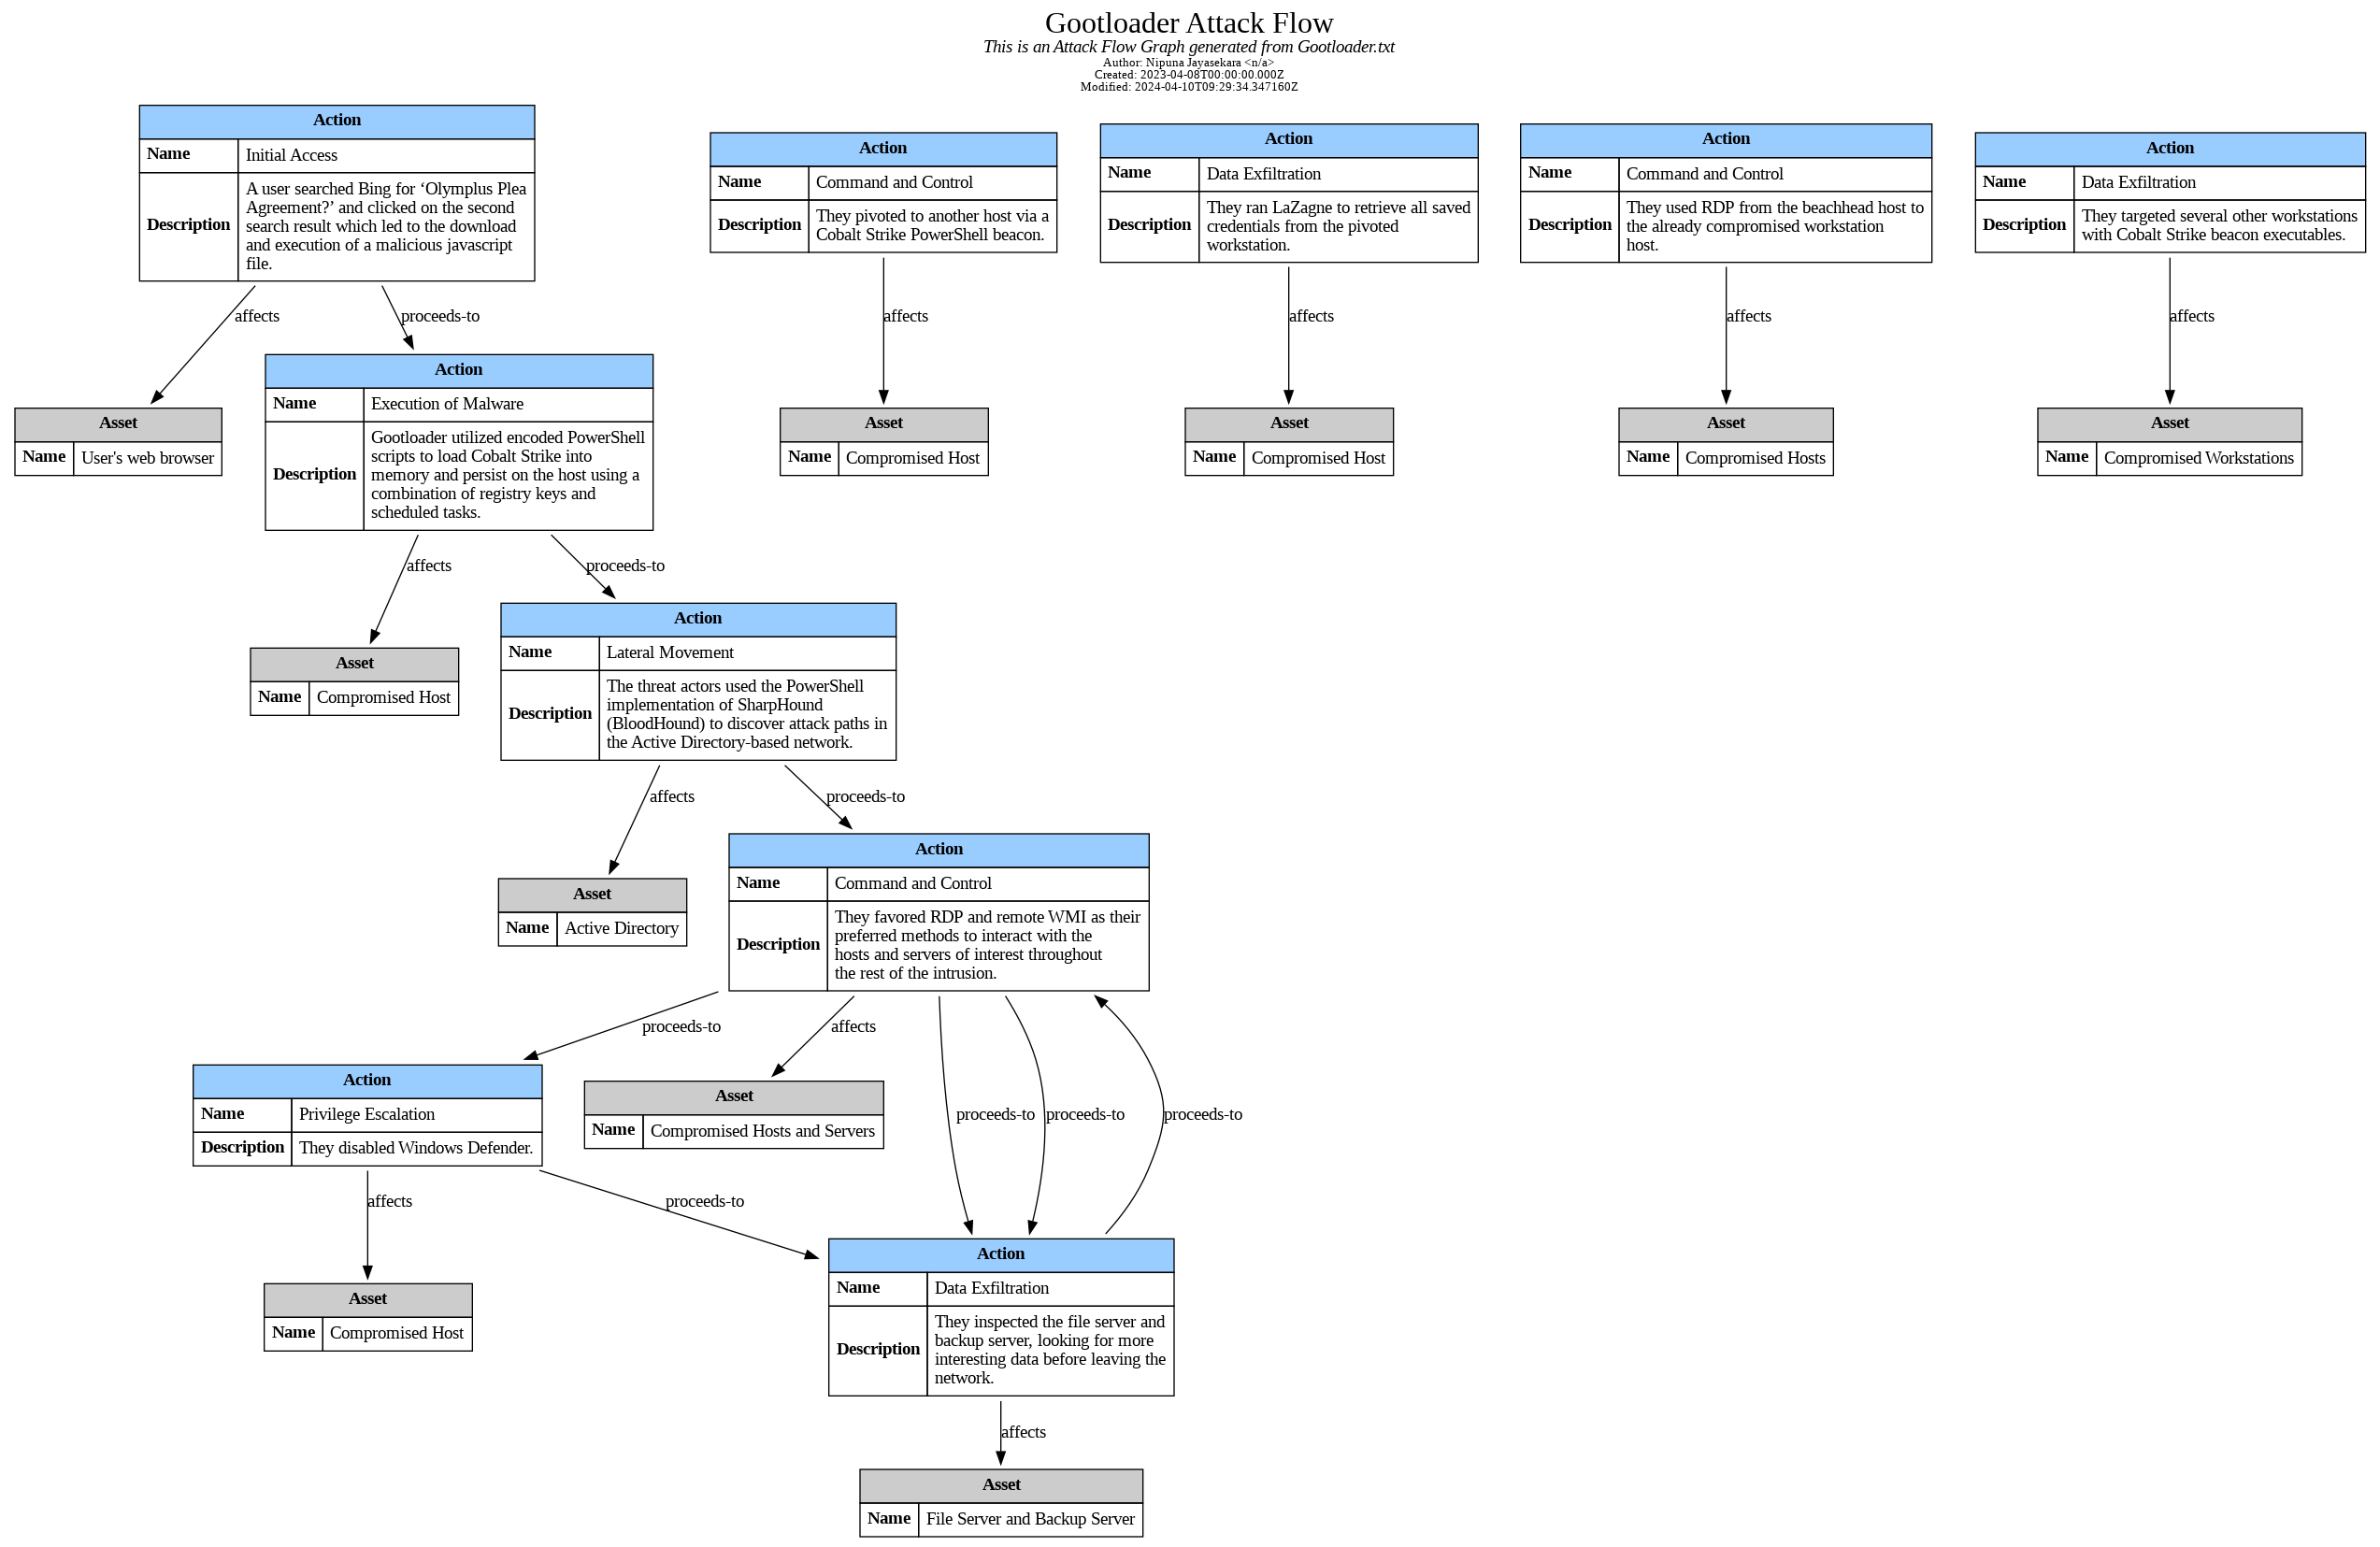

In [111]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [112]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/Gootloader.json
Accuracy: 0.00%


## Run \#9 - Ragnar

### Document Upload

In [113]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Files processed and stored.


### Answer,Graph Generation and Misc.

In [114]:
doc_processor.display_processed_texts()

Document: Ragnar.pdf
Word Count: 1234
Content: Ragnar Locker ransomware deploys virtual machine to dodge security Written by Mark Loman MAY 21, 202...
----------------------------------------------------------------------------------------------------


In [115]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [116]:
p9 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p9)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [117]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 93 seconds
[
    {
        "action_name": "Gain Initial Access",
        "tactic_id": "TA0001",
        "technique_id": "T1027",
        "sub_technique_id": "T1027.001",
        "evidence": "The attackers gained administrator-level access to the domain of a target and exfiltrated data.",
        "affected_assets": [
            "Domain"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Command and Scripting Interpreter"
        ]
    },
    {
        "action_name": "Command and Scripting Interpreter",
        "tactic_id": "TA0002",
        "technique_id": "T1059",
        "sub_technique_id": "T1059.001",
        "evidence": "The attackers used a GPO task to execute Microsoft Installer (msiexec.exe), passing parameters to download and silently install a crafted, unsigned MSI package.",
        "affected_assets": [
            "Targeted Device"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions"

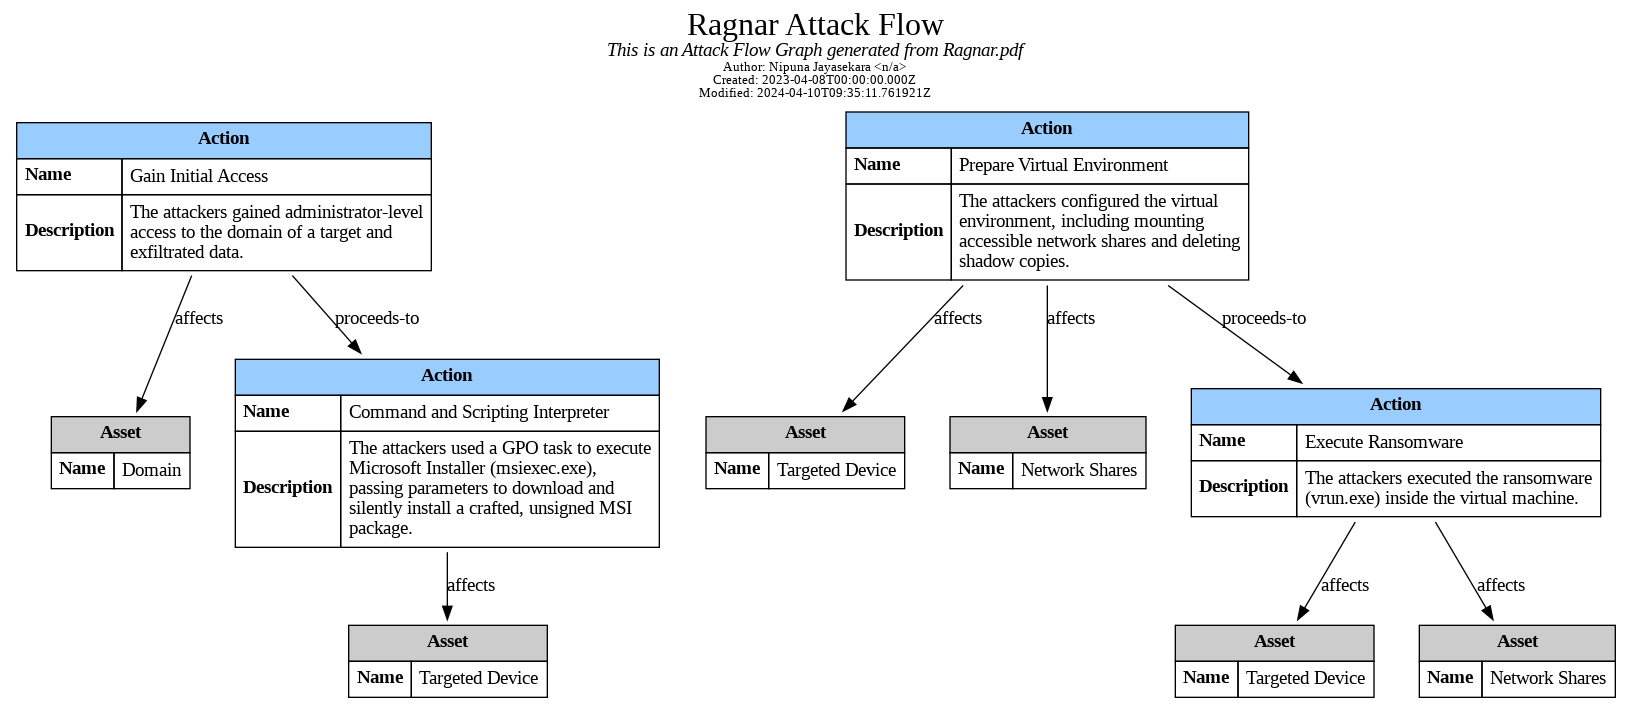

In [118]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [119]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/Ragnar%20Locker.json
Accuracy: 14.29%


## Run \#10 - Target Breach

### Document Upload

In [120]:
doc_processor = DocumentProcessor()

FileUpload(value={}, description='Upload', multiple=True)

IntText(value=0, description='Start Page:')

IntText(value=0, description='End Page:')

Button(description='Exclude Pages', style=ButtonStyle())

Button(description='Process Files', style=ButtonStyle())

Files processed and stored.


### Answer,Graph Generation and Misc.

In [121]:
doc_processor.display_processed_texts()

Document: Target_Breach.pdf
Word Count: 1334
Content: Part of a ZDNET Special Feature: Security and Privacy: New Challenges Home Tech Security Anatomy of ...
----------------------------------------------------------------------------------------------------


In [122]:
doc_name = list(doc_processor.get_processed_texts().keys())[0]
processed_texts = list(doc_processor.get_processed_texts().values())[0]
attack_name = doc_name.split('.')[0]

In [123]:
p10 = prompt.format(BODY=processed_texts)
prompt_processor = PromptProcessor(model_loader.model, model_loader.tokenizer)
answer = prompt_processor.run_prompt(p10)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [124]:
processed_answer = prompt_processor.process_answer(answer)

Time to Generate: 108 seconds
[
    {
        "action_name": "Preliminary survey",
        "tactic_id": "TA0001",
        "technique_id": "T1585",
        "sub_technique_id": "T1585.001",
        "evidence": "The attackers likely performed reconnaissance on Target's network by searching for information on the internet and using Target's Supplier Portal.",
        "affected_assets": [
            "Target's network infrastructure",
            "Target's Supplier Portal"
        ],
        "exploited_vulnerability": null,
        "proceeding_actions": [
            "Compromise third-party vendor"
        ]
    },
    {
        "action_name": "Compromise third-party vendor",
        "tactic_id": "TA0001",
        "technique_id": "T1192",
        "sub_technique_id": null,
        "evidence": "The attackers compromised Fazio Mechanical, a third-party vendor, by sending a phishing email that installed Citadel malware.",
        "affected_assets": [
            "Fazio Mechanical's network"
   

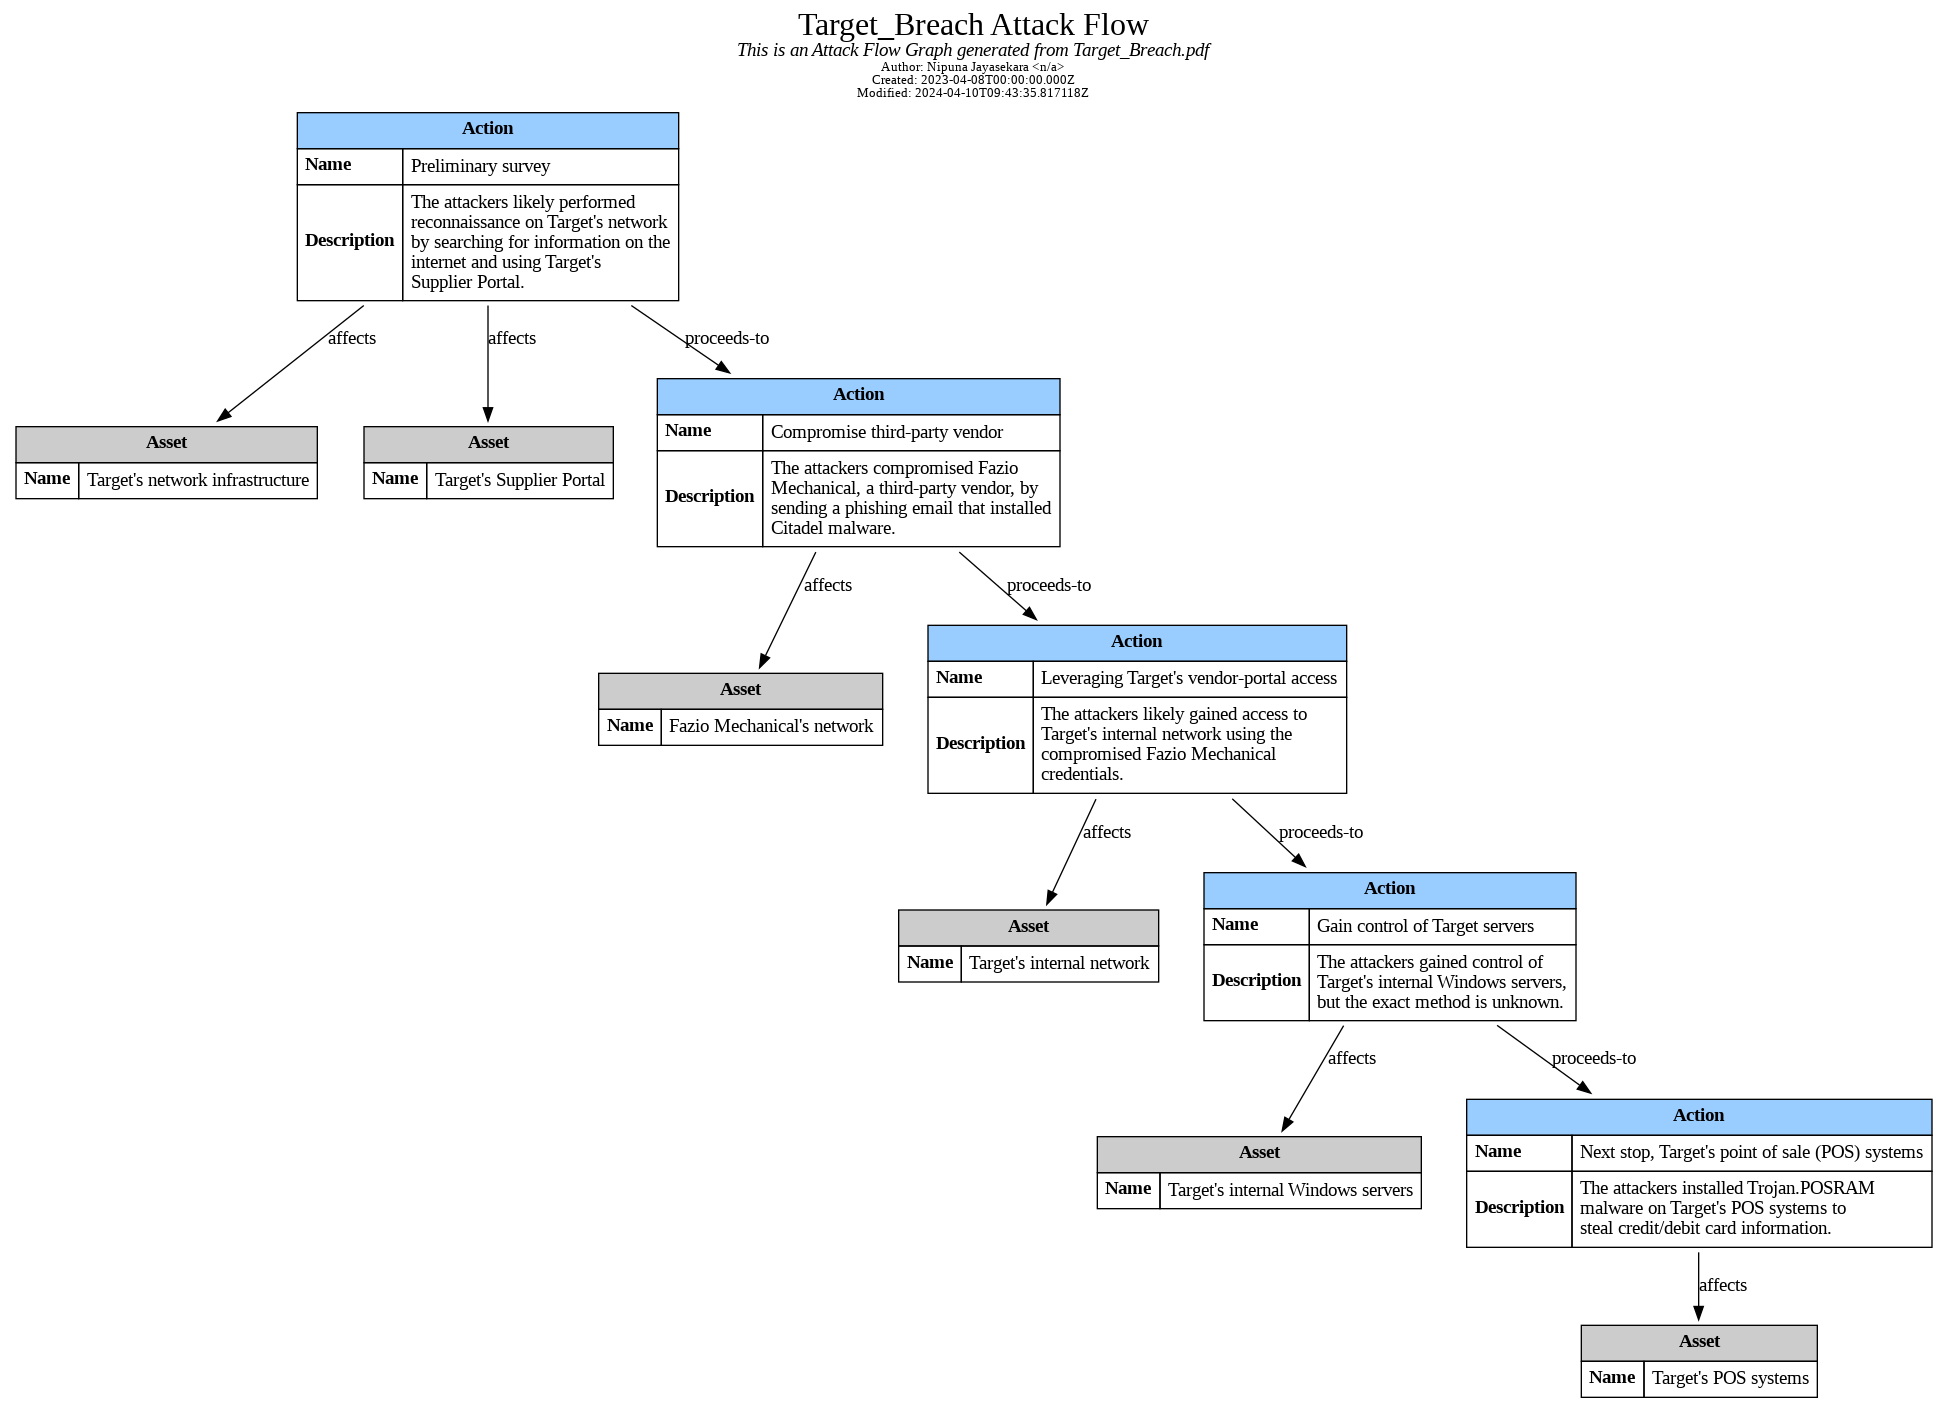

In [125]:
graph_generator = GraphGenerator()

# Convert the JSON data to STIX
stix_bundle = graph_generator.convert_json_to_stix(processed_answer)

# Convert the STIX bundle to a Graphviz DOT object
dot_obj = graph_generator.convert2dot(stix_bundle)

# Render the DOT object as an image
img_data = dot_obj.pipe(format='png')

# Create a PIL Image object from the image data
img = Image.open(BytesIO(img_data))

# Save the image to a file
img.save(f"{attack_name}.png")

# Display the image in the notebook
IPythonImage(img_data)

### Results

In [126]:
results_eval = ResultsEvaluation(stix_bundle, attack_name)
results_eval.evaluate()

Enter the MITRE ATTACK STIX URL: https://center-for-threat-informed-defense.github.io/attack-flow/corpus/Target%20Breach.json
Accuracy: 0.00%


In [130]:
headers = ['Attack Flow', 'Accuracy']
data = [(attack_flow, f"{accuracy:.2f}%") for attack_flow, accuracy in results_dict.items()]

table = tabulate(data, headers, tablefmt='grid')
print(table)

+---------------------------------------+------------+
| Attack Flow                           | Accuracy   |
+=======================================+============+
| CISA AA22-138B VMWare Workspace (Alt) | 50.00%     |
+---------------------------------------+------------+
| CISA Iranian APT                      | 62.50%     |
+---------------------------------------+------------+
| CobaltKitty                           | 0.00%      |
+---------------------------------------+------------+
| Conti Ransomware                      | 6.67%      |
+---------------------------------------+------------+
| DFIR - BumbleBee Round 2              | 6.67%      |
+---------------------------------------+------------+
| Equifax-Report                        | 0.00%      |
+---------------------------------------+------------+
| Gootloader                            | 0.00%      |
+---------------------------------------+------------+
| Ragnar                                | 14.29%     |
+---------